# Time Series - Clustering - Only Coefficients
Data Understanding and Preparation
- Explore and prepare the time series dataset.
- Preprocess the dataset in order to be able to run time series
clustering; motif/anomaly discovery and classification. If the dataset is
too big for these tasks, you can use approximations (e.g. SAX, PAA etc)

Motifs/Discords
- Analyze the dataset for finding motifs and/or anomalies. Visualize and
discuss them and their relationship with shapelets.

Clustering
- Use at least two clustering algorithm on time series using an
appropriate distance.
- Analyze the clusters and highlight similarities and differences and
visualize the clusters using at least 2 dimensionality reduction
techniques.

Classification
Define one (or more) classification task and solve it using:
- KNN with at least two distances
    - Euclidean/Manhattan
    - DTW
    - Shapelets
    - Analyze the shapelets retrieved
- At least one other method (rocket, muse, cnn, rnn etc)

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
                            
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle
import random

from IPython.display import Audio 
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

### TS libraries

In [2]:
#Time Series Preprocessing
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#Distances
from scipy.spatial.distance import euclidean, cityblock
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

#Time Series Approximation
from scipy.signal import decimate
from pyts.approximation import DiscreteFourierTransform, SymbolicAggregateApproximation
from sklearn.decomposition import TruncatedSVD, randomized_svd
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

#Time Series Clustering
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.pyplot import cm
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score,rand_score, adjusted_rand_score, mutual_info_score,\
                                adjusted_mutual_info_score, v_measure_score, fowlkes_mallows_score

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from dtaidistance import dtw

#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
def imp_data(data_filename, data_npy, fraction = 0.25, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    
    df_all = pd.concat([pd.read_csv(data_filename)['emotion'], pd.DataFrame(np.load(data_npy))], axis = 1)
    #df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    #print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = fraction
    df_train_s = df_train.groupby(targ).sample(frac = fraction, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)

    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)

    # scaling the time series
    #scl_mv = MinMaxScaler() # mu=0., std=1.
    #X = scl_mv.fit_transform(X)
    #X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [4]:
def imp_for_centroids(data_filename, fraction = 0.25, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    #print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = fraction
    df_train_s = df_train.groupby(targ).sample(frac = fraction, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)

    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)

    # scaling the time series
    #scl_mv = TimeSeriesScalerMinMax(mu=0., std=1.)
    #X = scl_mv.fit_transform(X)
    #X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [5]:
def plot_eval_clust(km_labels, y_clust, X_clust, data_name = ''):
    if len(np.unique(km_labels)) == 3:
        emotions = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']#['quiet','normal','loud']
    else:
        emotions = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

    tab = pd.crosstab(km_labels,y_clust)
    tab = tab.div(tab.sum(1).astype(float), axis=0)
    tab.plot(kind='bar', stacked=True,color=['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], width = 0.8, figsize = (8,5))

    plt.xlabel('Cluster', fontsize = 15)
    plt.xticks(rotation=0, fontsize = 15)
    plt.yticks(rotation=0, fontsize = 15)
    plt.ylabel('Emotion (%)', fontsize = 15)
    #rotate x labels 90 degrees

    plt.legend(emotions,loc='upper left',bbox_to_anchor=(1, 1), fontsize = 15)
    plt.show()

    print()
    print()

    scores_dict = {}

    amis = adjusted_mutual_info_score(y_clust, km_labels)
    ars = adjusted_rand_score(y_clust, km_labels)
    fms = fowlkes_mallows_score(y_clust, km_labels)
    ss = silhouette_score(X_clust, km_labels)
    score_names = ['adjusted_mutual_info_score', 'adjusted_rand_score', 'fowlkes_mallows_score', 'silhouette_score'] # good 1, bad usually 0 or negative
    scores_km = [amis, ars, fms, ss]
    for i in range(len(scores_km)):
        print(f'{score_names[i].capitalize()} = {round(scores_km[i],3)}')
        scores_dict[score_names[i]+'_'+data_name.upper()] = scores_km[i]

    return scores_dict

In [6]:
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [7]:
def plot_pca_clust(X_clust, km_labels, name = ''):    
    n_com = 2
    pca = PCA(n_components=n_com)
    pca.fit(X_clust)
    principalComponents = pca.transform(X_clust)
    principalDf = pd.DataFrame(data = principalComponents
                        , columns = ['pc'+str(i) for i in range(1,n_com+1)])
    
    # Kmeans centroids
    centroids = []
    for i in range(0,8):
        centroids.append(np.mean(principalDf[km_labels == i], axis = 0))
    centroids = pd.DataFrame(centroids, columns = ['pc1', 'pc2'])
    
    if len(np.unique(km_labels)) == 8:
        plt.scatter(principalDf[km_labels==0]['pc1'],principalDf[km_labels==0]['pc2'], s = 60, edgecolor = 'grey', color = 'blue')
        plt.scatter(principalDf[km_labels==1]['pc1'],principalDf[km_labels==1]['pc2'], s = 60, edgecolor = 'grey', color = 'forestgreen')
        plt.scatter(principalDf[km_labels==2]['pc1'],principalDf[km_labels==2]['pc2'], s = 60, edgecolor = 'grey', color = 'deepskyblue')
        plt.scatter(principalDf[km_labels==3]['pc1'],principalDf[km_labels==3]['pc2'], s = 60, edgecolor = 'grey', color = 'salmon')
        plt.scatter(principalDf[km_labels==4]['pc1'],principalDf[km_labels==4]['pc2'], s = 60, edgecolor = 'grey', color = 'limegreen')
        plt.scatter(principalDf[km_labels==5]['pc1'],principalDf[km_labels==5]['pc2'], s = 60, edgecolor = 'grey', color = 'goldenrod')
        plt.scatter(principalDf[km_labels==6]['pc1'],principalDf[km_labels==6]['pc2'], s = 60, edgecolor = 'grey', color = 'crimson')
        plt.scatter(principalDf[km_labels==7]['pc1'],principalDf[km_labels==7]['pc2'], s = 60, edgecolor = 'grey', color = 'cyan')

        
        edgecolor = 'k'
        plt.scatter(centroids.loc[0,'pc1'],centroids.loc[0,'pc2'], label='Centroid Cluster 1\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='blue',      )
        plt.scatter(centroids.loc[1,'pc1'],centroids.loc[1,'pc2'], label='Centroid Cluster 2\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='forestgreen')
        plt.scatter(centroids.loc[2,'pc1'],centroids.loc[2,'pc2'], label='Centroid Cluster 3\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='deepskyblue')
        plt.scatter(centroids.loc[3,'pc1'],centroids.loc[3,'pc2'], label='Centroid Cluster 4\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='salmon',    )
        plt.scatter(centroids.loc[4,'pc1'],centroids.loc[4,'pc2'], label='Centroid Cluster 5\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='limegreen', )
        plt.scatter(centroids.loc[5,'pc1'],centroids.loc[5,'pc2'], label='Centroid Cluster 6\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='goldenrod', )
        plt.scatter(centroids.loc[6,'pc1'],centroids.loc[6,'pc2'], label='Centroid Cluster 7\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='crimson',   )
        plt.scatter(centroids.loc[7,'pc1'],centroids.loc[7,'pc2'], label='Centroid Cluster 8\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='cyan',      )

        plt.title(f'{name.upper()}')
        plt.legend()
        plt.yticks(fontsize = 15)
        plt.xticks(fontsize = 15)
        plt.xlabel('Principal Component 1', fontsize = 15)
        plt.ylabel('Principal Component 2', fontsize = 15)
        plt.show()
        plt.close()
    

    else:
        plt.scatter(principalDf[km_labels==0]['pc1'],principalDf[km_labels==0]['pc2'], s = 60, edgecolor = 'grey', color = 'blue')
        plt.scatter(principalDf[km_labels==1]['pc1'],principalDf[km_labels==1]['pc2'], s = 60, edgecolor = 'grey', color = 'forestgreen')
        plt.scatter(principalDf[km_labels==2]['pc1'],principalDf[km_labels==2]['pc2'], s = 60, edgecolor = 'grey', color = 'crimson')


        # Kmeans centroids
        centroids = []
        for i in range(0,3):
            centroids.append(np.mean(principalDf[km_labels == i], axis = 0))
        centroids = pd.DataFrame(centroids, columns = ['pc1', 'pc2'])
        edgecolor = 'k'
        plt.scatter(centroids.loc[0,'pc1'],centroids.loc[0,'pc2'], label='Centroid Cluster 1\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='blue',      )
        plt.scatter(centroids.loc[1,'pc1'],centroids.loc[1,'pc2'], label='Centroid Cluster 2\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='forestgreen')
        plt.scatter(centroids.loc[2,'pc1'],centroids.loc[2,'pc2'], label='Centroid Cluster 3\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='crimson')

        plt.title(f'{name.upper()}')
        plt.legend()
        plt.yticks(fontsize = 15)
        plt.xticks(fontsize = 15)
        plt.xlabel('Principal Component 1', fontsize = 15)
        plt.ylabel('Principal Component 2', fontsize = 15)
        plt.show()
        plt.close()

In [8]:
def dtw_and_matrix(X_clust):
    X_clust = np.squeeze(X_clust)
    distance_matrix = []
    m = len(X_clust)    
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            distance_matrix.append(dtw.distance_fast(X_clust[i].astype('double'), X_clust[j].astype('double')))
    
    distance_matrix = np.array(distance_matrix)
    d_mat = squareform(distance_matrix)

    return distance_matrix, d_mat
    

In [9]:
def plot_dendr(d, name = '', method = 'complete', color_threshold = 0):
    
    data_link = linkage(d, method = method)
    res = dendrogram(data_link, truncate_mode = 'lastp', color_threshold = color_threshold, above_threshold_color='k')
    plt.title(f'{method.capitalize()} Linkage {name.upper()}')
    #calculate Cophenetic Correlation Coefficient
    c, coph_dists = cophenet(data_link, d)
    print(f'Cophenetic Coefficient: {c}')

In [10]:
np.random.seed(42)  # for reproducibility

## K-Means on coefficients (euclidean)

In [11]:
results = {}

In [12]:
fraction = 0.5
n_clusters = 8
metric = 'euclidean'

### SAX

In [13]:
X_clust_sax, y_clust_sax, df_sax = imp_data('data_ts\data_p_70_sax.csv', 'data_ts\\ts_p_70_sax.npy', fraction = fraction, emotions = n_clusters)
print(df_sax.shape)
df_sax.head()

(914, 101)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3,18,18,18,18,36,52,36,25,21,21,22,21,20,19,19,19,19,20,21,22,21,18,19,21,21,38,37,68,68,73,67,46,41,57,79,78,79,50,28,58,45,43,68,77,74,52,29,30,63,71,45,31,33,70,57,73,67,38,36,37,68,61,36,38,60,60,46,36,58,71,59,43,32,21,22,23,22,21,20,20,19,19,19,21,22,20,23,22,26,31,25,26,37,34,25,19,19,18,23,21
1,7,9,17,14,27,41,46,49,47,46,46,57,73,62,40,16,16,15,19,26,20,22,42,30,22,65,66,55,56,22,22,23,31,47,49,52,58,48,52,47,46,46,40,42,37,19,33,41,50,29,24,27,35,47,55,66,78,79,79,59,54,34,38,43,53,47,48,32,25,15,12,15,28,54,28,27,16,12,11,20,19,22,18,18,25,37,42,29,32,33,42,52,54,56,55,54,52,45,45,59,57
2,3,9,9,9,9,9,9,15,18,18,13,19,58,65,67,50,50,60,31,20,31,58,34,39,57,67,56,48,53,58,51,22,12,11,24,26,13,15,17,64,73,69,64,45,15,11,13,18,60,49,53,50,50,53,51,44,47,56,64,54,28,15,10,34,54,43,33,46,55,52,55,72,73,23,20,25,63,33,16,13,25,47,56,43,49,48,63,60,59,63,61,67,55,58,53,46,45,34,24,14,11
3,3,15,24,67,59,63,51,60,72,76,67,63,51,61,63,56,46,22,23,26,29,22,32,24,25,35,47,35,30,27,31,29,34,35,37,32,28,37,48,53,47,28,31,43,42,52,73,61,58,63,70,62,30,15,16,49,60,56,52,50,50,75,75,49,30,22,16,28,42,34,22,17,15,14,14,16,34,39,46,52,56,64,59,54,41,48,41,44,29,25,21,19,17,14,14,14,13,13,13,13,13
4,3,15,16,15,15,16,15,15,15,15,19,37,54,73,76,77,77,72,58,65,63,34,52,73,71,77,79,69,46,29,42,47,45,43,33,29,42,53,51,32,21,17,24,35,43,38,39,37,35,50,40,30,26,23,26,38,27,21,27,42,53,53,48,43,42,36,35,23,26,27,32,37,51,51,31,26,19,18,23,57,54,61,58,68,61,44,54,54,38,27,20,18,17,16,16,15,16,15,15,15,15


In [14]:
print('____________________SAX____________________')
print()

# computing kMeans
kmeans_sax = KMeans(n_clusters=n_clusters, #metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_sax.fit(X_clust_sax)

____________________SAX____________________



c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(max_iter=50, random_state=100)

Centroids' shape (8, 100)

KMeans assigned labels:
 [5 6 0 6 7 0 2 0 0 5 4 3 2 1 7 5 3 2 7 5 7 6 2 4 2 4 5 0 5 3 6 5 7 7 1 3 3
 4 7 0 2 5 6 2 7 2 6 3 0 4 4 0 4 0 7 3 4 0 5 6 3 6 6 2 5 0 0 6 5 6 7 7 6 3
 3 0 7 1 2 6 3 4 7 0 2 2 0 4 4 6 7 6 6 6 5 6 5 0 7 3 0 3 4 5 3 7 5 7 4 1 7
 2 3 5 6 2 2 7 6 3 2 0 0 4 0 5 6 4 6 0 4 3 7 7 1 7 2 1 4 2 6 0 4 5 0 6 7 4
 1 7 0 0 5 6 7 0 5 7 4 6 6 5 1 7 6 7 5 0 6 6 2 3 3 7 4 5 7 3 3 0 5 6 6 6 0
 0 5 6 4 6 7 1 7 0 6 5 0 4 4 4 2 6 2 3 7 3 0 7 0 4 5 1 1 7 0 7 2 7 0 4 7 5
 6 7 1 1 1 5 2 6 6 7 0 4 2 3 5 7 1 3 5 3 2 4 4 6 4 4 0 2 6 0 4 4 6 0 4 5 7
 4 2 0 4 0 7 7 1 7 3 3 1 3 7 1 0 2 4 6 0 6 6 3 2 6 5 0 6 3 1 7 0 6 3 4 1 2
 1 6 4 2 3 5 1 4 5 6 3 1 2 1 2 6 5 7 6 6 2 4 2 5 5 7 6 0 3 6 3 7 0 5 1 5 7
 4 3 3 5 6 3 6 3 1 1 0 7 1 4 1 1 3 6 0 0 7 0 4 1 6 6 5 7 2 6 4 5 5 6 1 7 2
 3 5 2 1 5 2 3 2 0 4 2 0 0 6 3 6 0 5 7 0 3 4 1 3 1 4 5 3 0 1 5 3 4 0 5 2 0
 7 6 0 1 2 7 2 5 2 6 2 6 6 1 5 0 2 4 0 1 2 6 3 3 4 2 2 5 6 7 7 6 5 2 2 1 4
 4 4 2 3 2 6 3 3 7 2 0 5 6 1 3 7 0 0 1 3 1 6 5 3

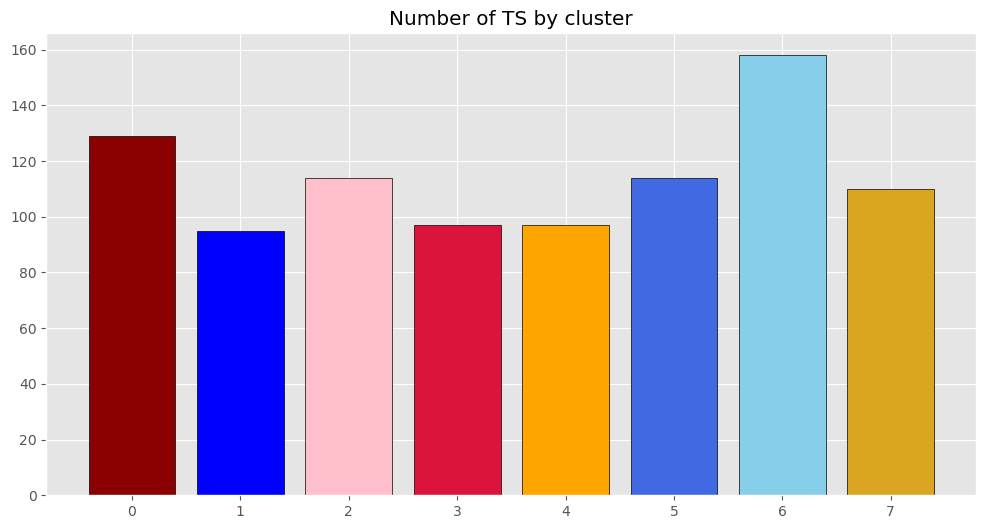


KMeans inertia:  22216159.511532445



In [15]:
# centroids
centroids_sax = kmeans_sax.cluster_centers_
print('Centroids\' shape',centroids_sax.shape)
print()

# inverse transform
#df_centroids_sax = dft_inverse_trasform(np.squeeze(centroids_sax), n_coefs=centroids_sax.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_sax)):
#    c = np.array(df_centroids_sax[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_sax = kmeans_sax.labels_
print('KMeans assigned labels:\n',km_labels_sax)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_sax, return_counts=True)[0], np.unique(km_labels_sax, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_sax = kmeans_sax.inertia_
print('KMeans inertia: ', inertia_sax)
print()

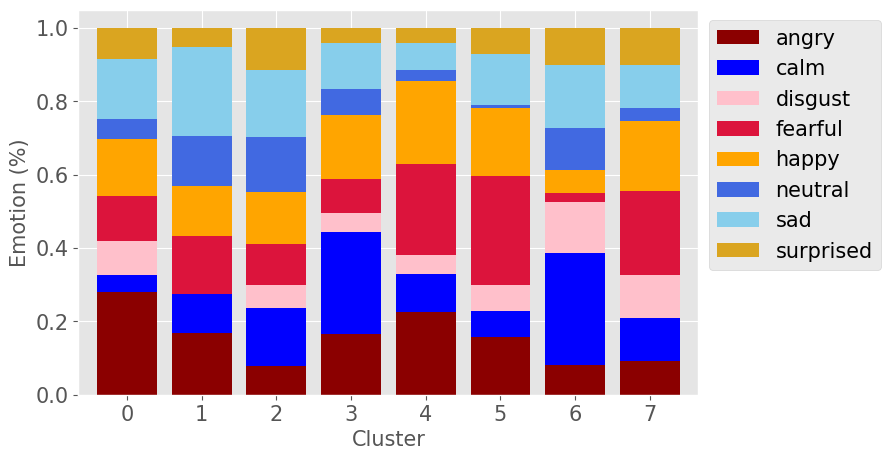



Adjusted_mutual_info_score = 0.047
Adjusted_rand_score = 0.028
Fowlkes_mallows_score = 0.155
Silhouette_score = 0.061


In [16]:
# emotions' distribution within different clusters and evaluation measures
res_km_sax = plot_eval_clust(km_labels_sax, y_clust_sax, X_clust_sax, 'km_sax')
results['km_sax'] = res_km_sax

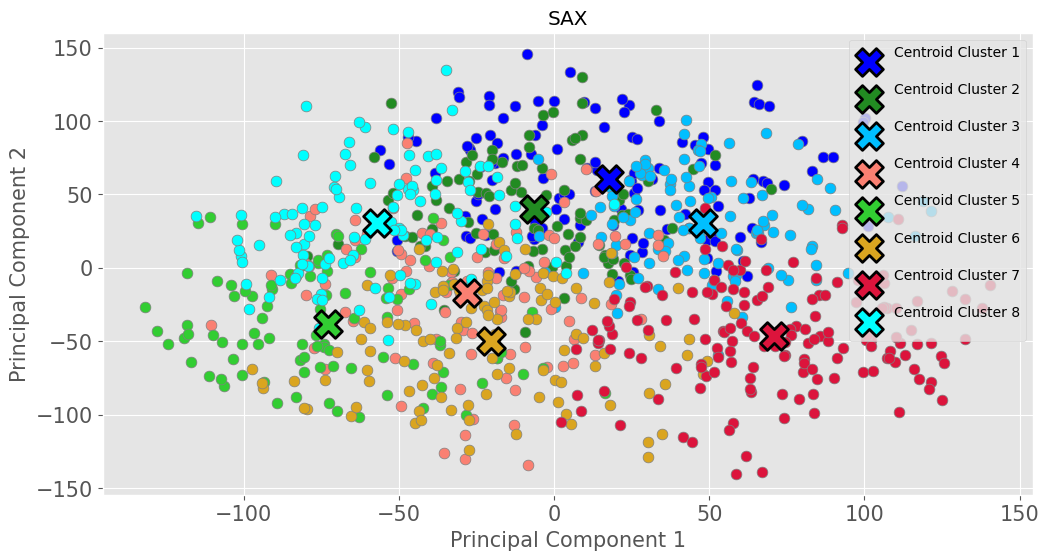

In [17]:
plot_pca_clust(X_clust_sax,km_labels_sax,name='sax')

### PAA

In [18]:
X_clust_paa, y_clust_paa, df_paa = imp_data('data_ts\data_p_100_paa.csv', 'data_ts\\ts_p_100_paa.npy', fraction = fraction, emotions = n_clusters)
print(df_paa.shape)
df_paa.head()

(914, 101)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3,-0.743124,-0.742956,-0.740565,-0.732495,-0.117772,0.418851,-0.123152,-0.481042,-0.630452,-0.625171,-0.581686,-0.605640,-0.638607,-0.709236,-0.680184,-0.682494,-0.691519,-0.670522,-0.609638,-0.579337,-0.624865,-0.720646,-0.674889,-0.624713,-0.606514,-0.049339,-0.070857,1.087695,1.083207,1.358775,1.026693,0.216700,0.039175,0.579117,3.077628,2.223941,2.310322,0.334445,-0.376455,0.613246,0.180731,0.097244,1.075687,1.933242,1.533540,0.388998,-0.335130,-0.295818,0.828261,1.243383,0.181652,-0.280185,-0.204972,1.198576,0.585634,1.387296,1.032932,-0.050632,-0.123708,-0.087401,1.046435,0.728896,-0.096758,-0.033873,0.697738,0.674838,0.189638,-0.103996,0.630611,1.244211,0.659404,0.105601,-0.238435,-0.611155,-0.588309,-0.557915,-0.596249,-0.607895,-0.648942,-0.666127,-0.709420,-0.706677,-0.682713,-0.610735,-0.595587,-0.670272,-0.554664,-0.590619,-0.426801,-0.283956,-0.483127,-0.433570,-0.090591,-0.179000,-0.459635,-0.683177,-0.693227,-0.720506,-0.543367,-0.635329
1,7,-1.172107,-0.788770,-0.902964,-0.408030,0.041484,0.196386,0.295004,0.235025,0.205268,0.220423,0.561167,1.422297,0.765921,0.002391,-0.799866,-0.826767,-0.885888,-0.701595,-0.445028,-0.640391,-0.569759,0.068400,-0.318238,-0.568337,0.892752,0.972589,0.502033,0.550569,-0.593489,-0.566480,-0.525362,-0.277409,0.238844,0.297836,0.391795,0.605455,0.267642,0.396051,0.230448,0.205115,0.203276,0.020117,0.063509,-0.074754,-0.699317,-0.196627,0.033175,0.345891,-0.337829,-0.519113,-0.407523,-0.132797,0.243903,0.503985,0.976883,2.029272,2.341173,2.287057,0.663570,0.458471,-0.180953,-0.041790,0.120033,0.420621,0.252880,0.253896,-0.226752,-0.476350,-0.873446,-1.000994,-0.871121,-0.352948,0.455570,-0.352554,-0.418159,-0.800686,-1.013297,-1.087478,-0.666044,-0.680795,-0.587495,-0.716260,-0.726234,-0.455800,-0.088060,0.064357,-0.345385,-0.245780,-0.194802,0.091099,0.400369,0.457406,0.542716,0.493592,0.478068,0.417528,0.166476,0.188097,0.636466,0.587267
2,3,-1.165620,-1.164890,-1.156868,-1.157832,-1.151186,-1.151918,-0.885690,-0.744633,-0.730392,-0.971448,-0.708422,0.624218,0.915425,1.024536,0.331759,0.326502,0.698368,-0.276766,-0.658018,-0.271227,0.599917,-0.183669,-0.020116,0.589728,1.014476,0.539003,0.260137,0.439432,0.633940,0.354352,-0.567145,-1.000183,-1.044663,-0.503962,-0.451263,-0.963015,-0.884391,-0.772121,0.859489,1.415191,1.149358,0.852904,0.158242,-0.865128,-1.084163,-0.980004,-0.719250,0.700875,0.314270,0.429957,0.334790,0.339919,0.444362,0.373500,0.154833,0.230941,0.535072,0.885577,0.470079,-0.373218,-0.859945,-1.114553,-0.177539,0.467010,0.111417,-0.198866,0.198341,0.504022,0.412578,0.494732,1.332664,1.372076,-0.545651,-0.648632,-0.462208,0.811873,-0.210018,-0.803303,-0.981027,-0.473956,0.231200,0.527456,0.116056,0.313700,0.282498,0.798671,0.708080,0.637366,0.799495,0.717337,0.986381,0.504276,0.623859,0.422985,0.203127,0.164677,-0.179906,-0.489225,-0.928393,-1.062606
3,3,-0.852526,-0.497910,1.027165,0.644129,0.827360,0.371391,0.686537,1.307241,1.685561,1.031825,0.840450,0.383427,0.743036,0.819138,0.531682,0.217327,-0.582332,-0.560474,-0.419818,-0.332699,-0.575395,-0.245868,-0.504371,-0.466249,-0.137978,0.230469,-0.134182,-0.289196,-0.418195,-0.275717,-0.335118,-0.174335,-0.134944,-0.091586,-0.236155,-0.380401,-0.081306,0.276152,0.439773,0.244246,-0.360056,-0.279032,0.109870,0.085166,0.406116,1.359669,0.721315,0.613508,0.838120,1.187080,0.792517,-0.288547,-0.868978,-0.815036,0.292242,0.702288,0.542508,0.400376,0.348059,0.329767,1.538697,1.548913,0.315418,-0.298747,-0.582719,-0.808512,-0.352352,0.067053,-0.187361,-0.596210,-0.762101,-0.884356,-0.923743,-0.932819,-0.836914,-0.187739,-0.012265,0.194675,0.413850,0.544794,0.881607,0.665545,0.483574,0.032421,0.257967,0.060959,0.129240,-0.351

In [19]:
print('____________________PAA____________________')
print()

# computing kMeans
kmeans_paa = KMeans(n_clusters=n_clusters, #metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_paa.fit(X_clust_paa)

____________________PAA____________________



c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(max_iter=50, random_state=100)

Centroids' shape (8, 100)

KMeans assigned labels:
 [4 5 6 5 6 0 7 0 6 6 2 3 5 1 6 6 3 0 2 2 2 5 0 6 7 2 6 0 4 3 5 4 4 0 1 3 3
 2 6 0 0 6 6 7 3 7 5 3 0 2 2 0 2 0 0 3 2 2 6 5 3 5 6 7 4 0 6 5 6 5 3 6 5 3
 3 0 3 3 7 5 3 2 2 0 7 7 0 2 2 5 6 5 5 5 4 5 4 0 6 5 0 3 2 4 3 6 4 6 2 1 6
 7 3 4 5 7 7 4 5 3 7 6 0 2 0 4 5 2 5 0 2 3 1 0 1 3 7 1 2 7 5 6 2 4 0 0 0 3
 1 6 0 0 6 5 4 0 4 2 2 5 6 6 3 3 5 2 4 0 5 5 5 3 3 0 2 4 6 3 3 0 6 5 5 5 0
 0 6 5 2 5 2 3 4 0 5 4 0 2 1 2 7 6 7 3 3 3 5 2 0 2 4 3 1 2 6 2 7 2 0 2 6 6
 5 0 1 1 1 4 0 5 6 2 0 2 7 3 2 0 1 3 4 3 7 2 2 5 2 4 0 7 5 0 2 6 5 0 2 4 6
 2 7 0 2 6 6 2 1 0 3 3 1 3 6 1 0 7 2 5 0 4 5 3 3 5 4 0 5 3 1 4 0 5 3 6 1 1
 1 5 2 7 3 4 1 2 4 5 3 1 7 1 0 5 4 6 5 5 1 2 7 4 4 2 5 0 3 5 3 2 0 4 3 6 2
 2 3 3 4 5 3 5 3 1 0 0 4 4 2 3 1 3 5 0 0 4 0 2 1 5 5 4 0 7 5 2 4 6 5 2 0 7
 3 4 7 1 6 7 3 7 0 2 7 0 0 5 3 5 0 2 0 0 3 2 1 3 1 3 4 3 0 1 4 3 2 0 4 7 6
 2 5 0 1 7 0 7 4 7 6 5 5 6 1 4 0 7 2 0 1 3 6 3 3 2 5 5 4 5 2 1 5 4 7 7 1 6
 2 2 7 3 0 5 3 3 6 5 0 2 5 1 3 2 6 0 1 3 1 5 4 3

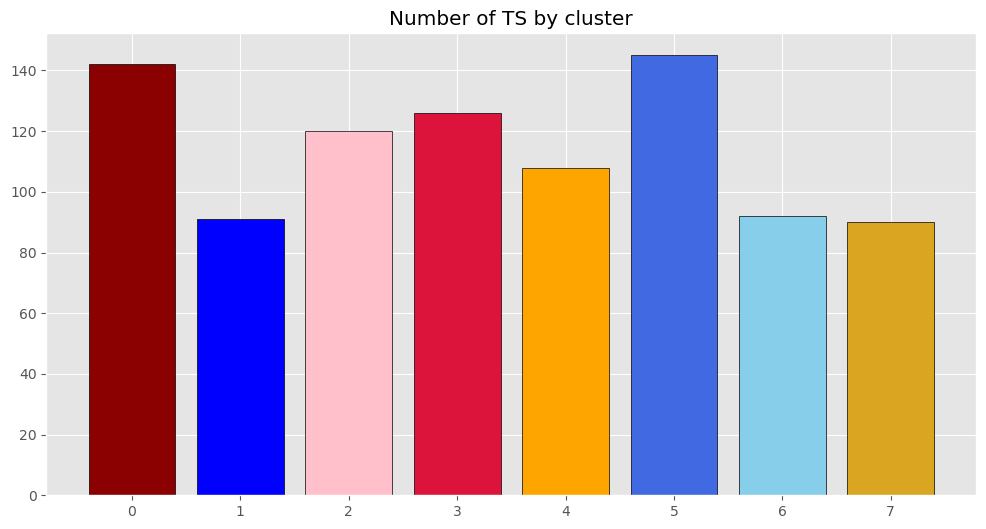


KMeans inertia:  35540.149245350905



In [20]:
# centroids
centroids_paa = kmeans_paa.cluster_centers_
print('Centroids\' shape',centroids_paa.shape)
print()

# inverse transform
#df_centroids_paa = dft_inverse_trasform(np.squeeze(centroids_paa), n_coefs=centroids_paa.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_paa)):
#    c = np.array(df_centroids_paa[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_paa = kmeans_paa.labels_
print('KMeans assigned labels:\n',km_labels_paa)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_paa, return_counts=True)[0], np.unique(km_labels_paa, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_paa = kmeans_paa.inertia_
print('KMeans inertia: ', inertia_paa)
print()

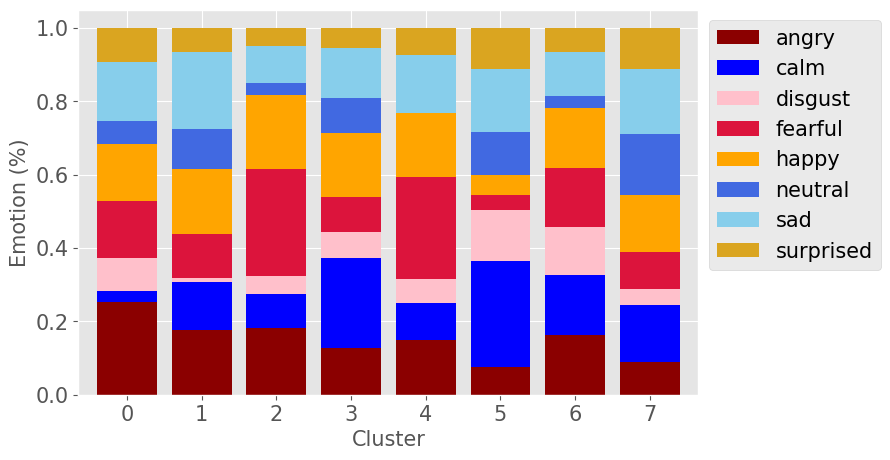



Adjusted_mutual_info_score = 0.038
Adjusted_rand_score = 0.023
Fowlkes_mallows_score = 0.151
Silhouette_score = 0.055


In [21]:
# emotions' distribution within different clusters and evaluation measures
res_km_paa = plot_eval_clust(km_labels_paa, y_clust_paa, X_clust_paa, 'km_paa')
results['km_paa'] = res_km_paa

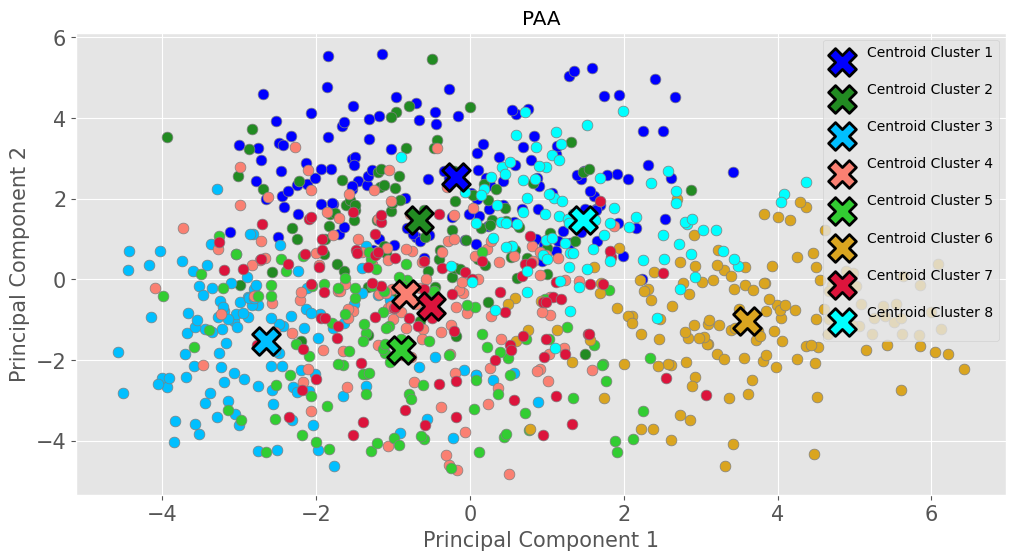

In [22]:
plot_pca_clust(X_clust_paa,km_labels_paa,'paa')

### DFT

In [23]:
X_clust_dft, y_clust_dft, df_dft = imp_data('data_ts\data_p_100_dft.csv', 'data_ts\\ts_p_100_dft.npy', fraction = fraction, emotions = n_clusters)
print(df_dft.shape)
df_dft.head()

(914, 101)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3,-2.060574e-13,-1081.533127,-259.172778,103.926630,252.167121,517.428277,1.506656,-205.064787,-136.939222,-292.856087,35.475299,49.701919,-75.657407,25.465766,-37.662040,-255.289737,-14.494962,33.666756,-114.011293,-173.547427,54.710528,202.662141,190.007841,-146.549194,-266.254433,-134.865365,194.617961,362.166930,216.437506,-215.565708,-225.097505,99.176218,276.605661,121.928578,-79.439505,128.796633,90.344068,-209.763958,-53.834926,327.894794,92.201985,-133.086138,-98.598408,-97.690072,47.174777,168.689791,-143.467463,-188.018199,90.043927,21.130115,-162.642795,32.175801,51.671031,-85.081086,-28.271201,38.744321,-39.901411,-70.203436,45.896527,74.679880,40.026352,-116.916500,-7.529102,27.999239,108.465370,6.229825,-36.564019,-75.071891,45.958741,4.841401,57.665970,66.286775,-94.704597,-26.629103,102.792221,25.396227,-48.705006,37.105110,34.826157,-10.184894,32.579952,77.798389,-66.440086,-148.222939,25.867055,127.557412,1.326456,-16.748969,-56.280664,-68.008503,-42.603401,21.759790,85.685310,19.666203,-109.706415,-55.133414,36.925926,-19.834824,-20.952593,-13.150775
1,7,5.968559e-13,-238.868446,-151.609030,485.351136,-118.668311,125.613750,453.015520,-285.622251,-270.787584,-97.762318,258.609827,-518.600855,-67.820943,45.210923,378.255733,5.806225,228.972695,182.635366,-81.408981,-303.444125,58.588116,223.617565,-155.896805,30.444634,245.452080,-297.814072,-179.904312,70.296895,259.529963,115.265293,274.739595,64.331924,97.267507,-10.363254,36.087215,24.396759,-61.395918,160.980582,68.611099,-95.679501,-72.745819,26.628341,68.331989,-100.083929,112.738440,58.164732,144.098762,-3.700121,-17.848192,49.525465,17.407750,-23.631812,42.932172,-31.977478,61.689443,44.152159,-20.296055,-45.373791,-44.454506,-89.218709,44.787829,-104.910375,49.892119,73.888402,47.074044,54.796988,-1.841606,-71.223536,-19.951561,-94.233668,38.438427,27.477913,77.958887,31.832874,21.098153,-42.568388,-54.029376,-47.135354,81.547163,77.125111,16.954849,8.674048,21.808055,17.789041,-2.254668,-3.749750,23.937634,27.457644,83.555804,7.738362,16.944663,-25.263008,-20.385420,23.946144,-18.872558,-32.460217,88.088459,-32.449549,-20.802644,-12.352910
2,3,-2.433609e-13,-208.783654,197.315144,-287.555455,114.312084,-464.595033,399.246948,-248.475670,413.433369,-350.374356,75.326208,-192.860574,-187.658062,272.024058,533.445804,145.538606,-267.260571,-238.471788,-147.069358,112.286830,-5.647101,-271.740966,-167.794570,47.469793,282.131762,-88.940146,-150.093300,64.826964,242.844681,-2.436245,-89.278103,-26.466143,-216.372838,264.883940,186.569663,-175.222689,-79.314336,-150.084717,-144.198717,20.334747,-32.356837,171.580098,-103.177631,-205.113689,220.807914,-112.888110,116.741646,187.330899,-67.189103,154.313526,61.241510,-118.765021,-124.446508,-57.886572,-104.995404,68.943178,91.706893,-5.833275,46.814972,17.147209,-65.558578,10.096095,-10.700947,-42.463000,-21.821308,27.622528,78.622811,-10.393734,-22.980918,-16.502209,71.695277,52.319710,-45.613641,-41.794257,-27.480601,80.302533,52.131683,-123.147614,-24.864966,-95.432363,-66.261554,74.518820,-43.480591,67.879095,55.820990,11.852119,46.736008,130.236427,-7.250289,1.350635,-32.076708,-85.600376,105.788410,-79.419211,-18.350186,46.443944,-40.135127,64.653013,11.249015,-93.212091
3,3,-2.113865e-13,-227.707630,-149.956614,286.780668,-314.348732,-425.380546,-441.283949,-302.841739,-621.088956,62.602039,-408.717270,-135.836112,275.419809,-135.691299,-95.151905,-1.016515,158.034136,-70.439964,-341.321606,76.023554,142.336757,-140.265267,-36.871314,-86.759375,-45.720811,100.548944,-71.777225,-113.656235,27.233673,-20.890060,-162.877561,140.864366,-13.927556,-415.460975,-96.589796,55.579847,42.475782,-269.561374,104.42

In [24]:
print('____________________DFT____________________')
print()

# computing kMeans
kmeans_dft = KMeans(n_clusters=n_clusters, #metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_dft.fit(X_clust_dft)

____________________DFT____________________



c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(max_iter=50, random_state=100)

Centroids' shape (8, 100)

KMeans assigned labels:
 [4 2 0 2 0 6 3 0 0 0 7 5 2 1 4 0 5 6 0 4 7 2 6 0 3 7 0 6 4 5 2 4 4 6 1 5 7
 7 1 0 3 0 0 3 6 3 2 5 6 7 7 6 4 6 6 5 7 6 0 2 5 2 0 3 4 6 0 2 0 2 6 0 2 5
 5 6 7 7 3 2 5 7 7 0 3 3 6 7 7 2 0 2 2 2 4 2 4 6 0 2 6 5 7 4 5 7 4 5 7 1 0
 3 5 4 2 3 3 4 2 5 3 0 6 7 6 4 2 7 2 2 7 5 6 6 1 5 7 1 4 3 2 0 7 4 6 6 6 7
 1 0 2 6 0 2 6 6 4 7 7 2 0 0 5 5 2 7 4 6 2 2 2 5 5 6 7 5 7 5 5 6 0 2 2 2 6
 6 0 2 7 2 7 5 6 6 2 4 6 7 1 7 3 0 3 7 7 5 2 7 6 7 4 5 1 7 0 1 3 7 6 7 0 0
 2 6 1 1 1 4 3 2 0 5 6 5 3 7 4 6 1 5 4 7 3 7 7 2 7 4 6 3 2 6 7 7 2 6 7 4 6
 7 1 6 7 0 0 5 1 6 5 5 1 5 0 1 6 3 4 2 6 2 2 5 2 2 4 6 2 7 1 6 0 2 7 0 1 1
 1 2 7 3 5 4 1 4 4 2 5 1 1 1 6 2 4 0 2 2 1 7 3 4 4 5 2 6 5 2 5 4 6 4 5 4 6
 7 5 5 4 2 5 2 6 1 6 6 6 1 7 2 1 5 2 6 0 6 6 7 1 2 2 4 6 3 2 7 4 4 2 7 6 3
 5 4 3 1 0 3 5 3 1 4 3 6 6 0 5 2 6 4 6 6 7 7 1 5 1 7 4 5 0 1 4 5 7 6 4 3 0
 7 2 6 1 3 6 3 4 3 0 2 2 0 1 4 6 3 4 6 1 5 0 7 5 7 2 2 4 2 4 1 2 4 3 3 1 0
 7 7 3 5 6 2 5 5 0 2 6 4 2 1 5 7 0 6 1 5 1 2 4 5

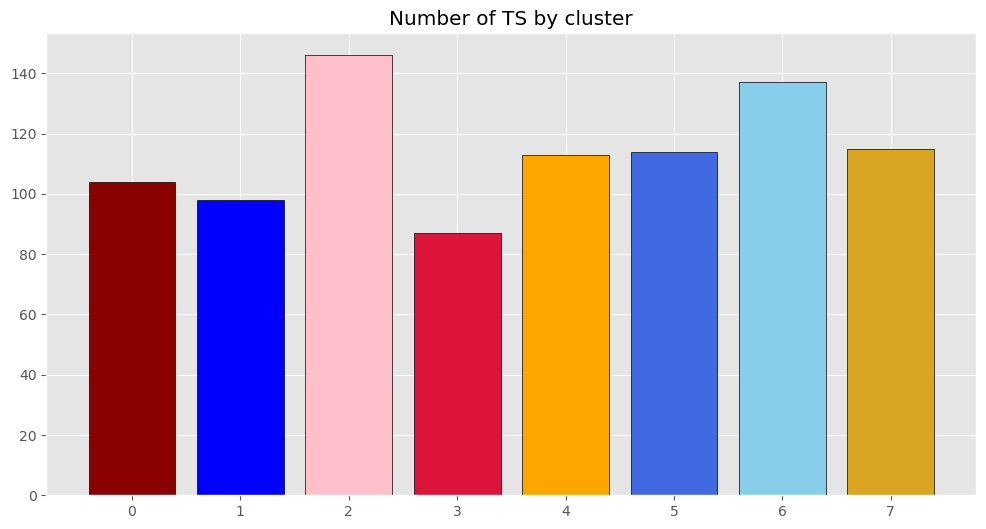


KMeans inertia:  1674473534.2338297



In [25]:
# centroids
centroids_dft = kmeans_dft.cluster_centers_
print('Centroids\' shape',centroids_dft.shape)
print()

# inverse transform
#df_centroids_dft = dft_inverse_trasform(np.squeeze(centroids_dft), n_coefs=centroids_dft.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_dft)):
#    c = np.array(df_centroids_dft[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_dft = kmeans_dft.labels_
print('KMeans assigned labels:\n',km_labels_dft)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_dft, return_counts=True)[0], np.unique(km_labels_dft, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_dft = kmeans_dft.inertia_
print('KMeans inertia: ', inertia_dft)
print()

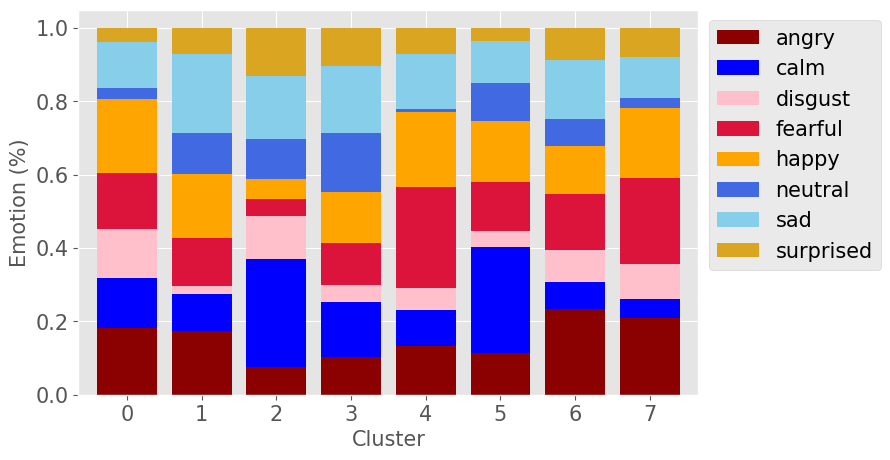



Adjusted_mutual_info_score = 0.034
Adjusted_rand_score = 0.021
Fowlkes_mallows_score = 0.149
Silhouette_score = 0.052


In [26]:
# emotions' distribution within different clusters and evaluation measures
res_km_dft = plot_eval_clust(km_labels_dft, y_clust_dft, X_clust_dft, 'km_dft')
results['km_dft'] = res_km_dft

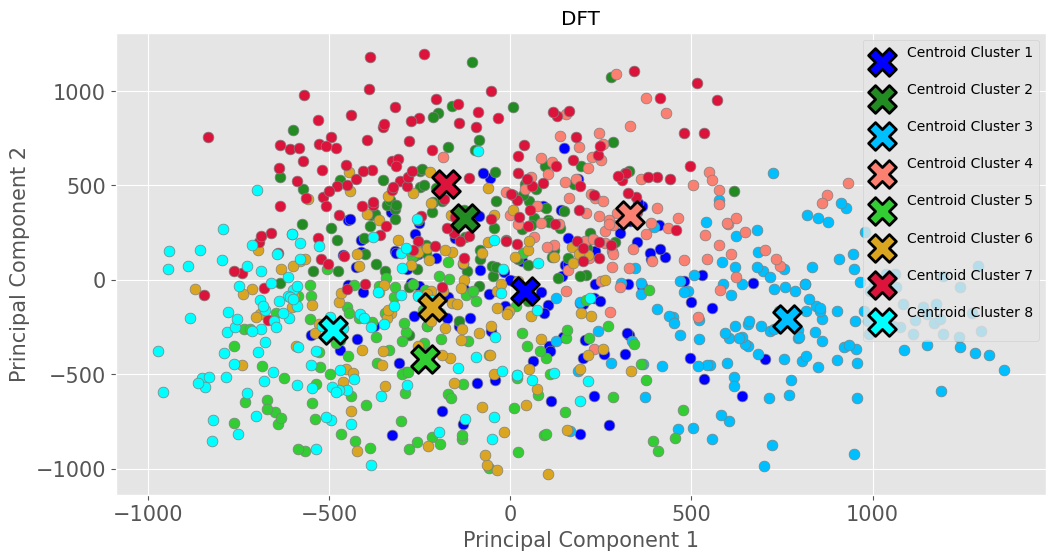

In [27]:
plot_pca_clust(X_clust_dft,km_labels_dft,'dft')

In [28]:
print('EUCLIDEAN')
pd.DataFrame(results.values()).T

EUCLIDEAN


,0,1,2
adjusted_mutual_info_score_KM_SAX,0.046696,NaN,NaN
adjusted_rand_score_KM_SAX,0.027519,NaN,NaN
fowlkes_mallows_score_KM_SAX,0.155081,NaN,NaN
silhouette_score_KM_SAX,0.060960,NaN,NaN
adjusted_mutual_info_score_KM_PAA,NaN,0.038391,NaN
adjusted_rand_score_KM_PAA,NaN,0.022662,NaN
fowlkes_mallows_score_KM_PAA,NaN,0.151119,NaN
silhouette_score_KM_PAA,NaN,0.054913,NaN
adjusted_mutual_info_score_KM_DFT,NaN,NaN,0.034335
adjusted_rand_score_KM_DFT,NaN,NaN,0.020641


## K-Means on coefficients (DTW)

In [29]:
results = {}

In [30]:
n_clusters = 8
metric = 'dtw'

### SAX

In [31]:
X_clust_sax, y_clust_sax, df_sax = imp_data('data_ts\data_p_70_sax.csv', 'data_ts\\ts_p_70_sax.npy', fraction = fraction, emotions = n_clusters)
print(df_sax.shape)
df_sax.head()

(914, 101)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3,18,18,18,18,36,52,36,25,21,21,22,21,20,19,19,19,19,20,21,22,21,18,19,21,21,38,37,68,68,73,67,46,41,57,79,78,79,50,28,58,45,43,68,77,74,52,29,30,63,71,45,31,33,70,57,73,67,38,36,37,68,61,36,38,60,60,46,36,58,71,59,43,32,21,22,23,22,21,20,20,19,19,19,21,22,20,23,22,26,31,25,26,37,34,25,19,19,18,23,21
1,7,9,17,14,27,41,46,49,47,46,46,57,73,62,40,16,16,15,19,26,20,22,42,30,22,65,66,55,56,22,22,23,31,47,49,52,58,48,52,47,46,46,40,42,37,19,33,41,50,29,24,27,35,47,55,66,78,79,79,59,54,34,38,43,53,47,48,32,25,15,12,15,28,54,28,27,16,12,11,20,19,22,18,18,25,37,42,29,32,33,42,52,54,56,55,54,52,45,45,59,57
2,3,9,9,9,9,9,9,15,18,18,13,19,58,65,67,50,50,60,31,20,31,58,34,39,57,67,56,48,53,58,51,22,12,11,24,26,13,15,17,64,73,69,64,45,15,11,13,18,60,49,53,50,50,53,51,44,47,56,64,54,28,15,10,34,54,43,33,46,55,52,55,72,73,23,20,25,63,33,16,13,25,47,56,43,49,48,63,60,59,63,61,67,55,58,53,46,45,34,24,14,11
3,3,15,24,67,59,63,51,60,72,76,67,63,51,61,63,56,46,22,23,26,29,22,32,24,25,35,47,35,30,27,31,29,34,35,37,32,28,37,48,53,47,28,31,43,42,52,73,61,58,63,70,62,30,15,16,49,60,56,52,50,50,75,75,49,30,22,16,28,42,34,22,17,15,14,14,16,34,39,46,52,56,64,59,54,41,48,41,44,29,25,21,19,17,14,14,14,13,13,13,13,13
4,3,15,16,15,15,16,15,15,15,15,19,37,54,73,76,77,77,72,58,65,63,34,52,73,71,77,79,69,46,29,42,47,45,43,33,29,42,53,51,32,21,17,24,35,43,38,39,37,35,50,40,30,26,23,26,38,27,21,27,42,53,53,48,43,42,36,35,23,26,27,32,37,51,51,31,26,19,18,23,57,54,61,58,68,61,44,54,54,38,27,20,18,17,16,16,15,16,15,15,15,15


In [32]:
print('____________________SAX____________________')
print()

# computing kMeans
kmeans_sax = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=5, init='k-means++', random_state=100, max_iter_barycenter=5)
kmeans_sax.fit(X_clust_sax)

____________________SAX____________________



TimeSeriesKMeans(max_iter=5, max_iter_barycenter=5, metric='dtw', n_clusters=8,
                 random_state=100)

Centroids' shape (8, 100, 1)

KMeans assigned labels:
 [6 0 3 4 6 6 1 3 3 6 7 3 5 3 2 3 7 3 1 2 3 5 6 6 2 2 6 1 1 7 1 2 3 1 7 4 3
 2 3 1 0 3 4 1 2 7 4 4 3 3 7 7 6 4 0 3 6 6 6 6 3 5 5 6 6 6 1 5 4 5 6 4 5 7
 1 0 0 0 1 4 6 2 0 4 3 4 2 2 2 5 4 5 4 4 0 5 6 2 3 6 6 3 6 2 2 6 1 4 2 3 6
 1 0 6 4 1 1 3 3 1 2 6 3 3 2 6 1 2 5 2 3 4 3 2 3 0 6 3 6 4 4 2 6 3 2 6 3 6
 3 5 6 6 3 3 6 2 6 2 7 5 3 6 7 2 5 4 6 6 5 4 1 3 3 6 3 5 6 2 1 7 6 3 5 1 2
 6 1 5 2 0 6 1 3 3 5 6 2 2 1 6 3 0 1 6 6 7 2 3 2 0 3 0 1 3 3 6 1 0 7 6 2 3
 6 2 2 3 3 2 0 5 3 3 2 1 1 0 6 1 4 3 6 0 2 4 6 1 6 4 2 7 5 4 3 2 5 3 6 6 3
 6 6 3 3 2 1 6 2 4 3 2 3 7 3 2 2 3 6 4 2 4 5 7 6 6 6 3 4 0 7 3 0 6 5 5 3 3
 3 1 6 4 3 1 3 1 6 5 7 6 3 2 0 5 0 4 5 1 2 3 2 6 6 1 5 2 4 4 7 6 3 3 0 6 2
 4 1 7 3 5 7 5 2 4 0 3 3 1 6 5 3 3 5 2 3 3 3 7 1 5 1 2 7 1 5 6 2 4 5 2 6 3
 4 1 1 3 4 1 3 3 7 3 1 0 2 5 2 1 6 3 3 3 6 6 7 6 7 0 3 3 3 7 3 3 6 3 4 1 5
 3 1 3 0 2 6 1 4 6 1 1 5 3 3 1 6 1 2 3 1 6 1 0 3 6 1 5 3 4 0 2 5 0 4 3 1 1
 2 6 1 4 3 5 7 2 4 1 3 6 5 1 1 6 2 2 3 7 2 4 

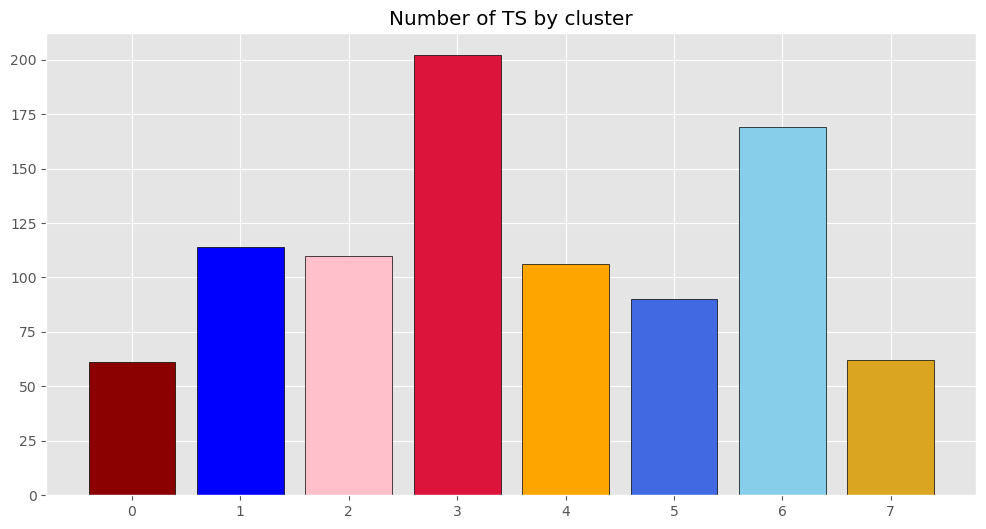


KMeans inertia:  3846.0542092036917



In [33]:
# centroids
centroids_sax = kmeans_sax.cluster_centers_
print('Centroids\' shape',centroids_sax.shape)
print()

# inverse transform
#df_centroids_sax = dft_inverse_trasform(np.squeeze(centroids_sax), n_coefs=centroids_sax.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_sax)):
#    c = np.array(df_centroids_sax[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_sax = kmeans_sax.labels_
print('KMeans assigned labels:\n',km_labels_sax)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_sax, return_counts=True)[0], np.unique(km_labels_sax, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_sax = kmeans_sax.inertia_
print('KMeans inertia: ', inertia_sax)
print()

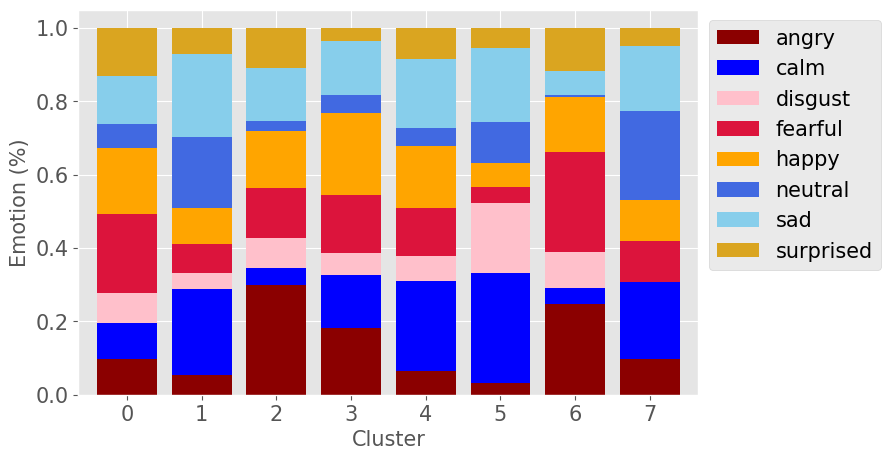



Adjusted_mutual_info_score = 0.059
Adjusted_rand_score = 0.035
Fowlkes_mallows_score = 0.17
Silhouette_score = -0.023


In [34]:
# emotions' distribution within different clusters and evaluation measures
res_km_sax = plot_eval_clust(km_labels_sax, y_clust_sax, X_clust_sax, 'km_sax')
results['km_sax'] = res_km_sax

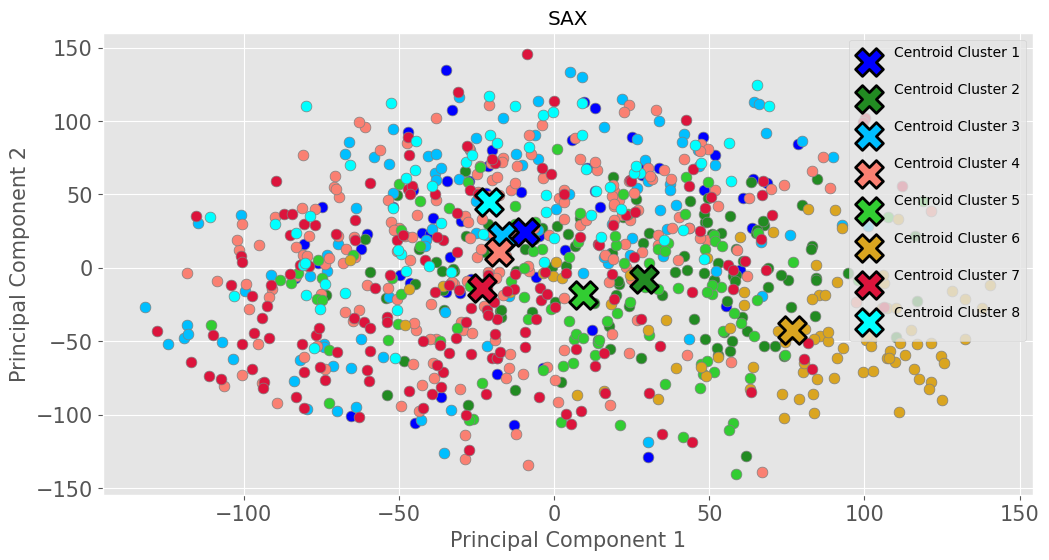

In [35]:
plot_pca_clust(X_clust_sax,km_labels_sax,name='sax')

### PAA

In [36]:
X_clust_paa, y_clust_paa, df_paa = imp_data('data_ts\data_p_100_paa.csv', 'data_ts\\ts_p_100_paa.npy', fraction = fraction, emotions = n_clusters)
print(df_paa.shape)
df_paa.head()

(914, 101)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3,-0.743124,-0.742956,-0.740565,-0.732495,-0.117772,0.418851,-0.123152,-0.481042,-0.630452,-0.625171,-0.581686,-0.605640,-0.638607,-0.709236,-0.680184,-0.682494,-0.691519,-0.670522,-0.609638,-0.579337,-0.624865,-0.720646,-0.674889,-0.624713,-0.606514,-0.049339,-0.070857,1.087695,1.083207,1.358775,1.026693,0.216700,0.039175,0.579117,3.077628,2.223941,2.310322,0.334445,-0.376455,0.613246,0.180731,0.097244,1.075687,1.933242,1.533540,0.388998,-0.335130,-0.295818,0.828261,1.243383,0.181652,-0.280185,-0.204972,1.198576,0.585634,1.387296,1.032932,-0.050632,-0.123708,-0.087401,1.046435,0.728896,-0.096758,-0.033873,0.697738,0.674838,0.189638,-0.103996,0.630611,1.244211,0.659404,0.105601,-0.238435,-0.611155,-0.588309,-0.557915,-0.596249,-0.607895,-0.648942,-0.666127,-0.709420,-0.706677,-0.682713,-0.610735,-0.595587,-0.670272,-0.554664,-0.590619,-0.426801,-0.283956,-0.483127,-0.433570,-0.090591,-0.179000,-0.459635,-0.683177,-0.693227,-0.720506,-0.543367,-0.635329
1,7,-1.172107,-0.788770,-0.902964,-0.408030,0.041484,0.196386,0.295004,0.235025,0.205268,0.220423,0.561167,1.422297,0.765921,0.002391,-0.799866,-0.826767,-0.885888,-0.701595,-0.445028,-0.640391,-0.569759,0.068400,-0.318238,-0.568337,0.892752,0.972589,0.502033,0.550569,-0.593489,-0.566480,-0.525362,-0.277409,0.238844,0.297836,0.391795,0.605455,0.267642,0.396051,0.230448,0.205115,0.203276,0.020117,0.063509,-0.074754,-0.699317,-0.196627,0.033175,0.345891,-0.337829,-0.519113,-0.407523,-0.132797,0.243903,0.503985,0.976883,2.029272,2.341173,2.287057,0.663570,0.458471,-0.180953,-0.041790,0.120033,0.420621,0.252880,0.253896,-0.226752,-0.476350,-0.873446,-1.000994,-0.871121,-0.352948,0.455570,-0.352554,-0.418159,-0.800686,-1.013297,-1.087478,-0.666044,-0.680795,-0.587495,-0.716260,-0.726234,-0.455800,-0.088060,0.064357,-0.345385,-0.245780,-0.194802,0.091099,0.400369,0.457406,0.542716,0.493592,0.478068,0.417528,0.166476,0.188097,0.636466,0.587267
2,3,-1.165620,-1.164890,-1.156868,-1.157832,-1.151186,-1.151918,-0.885690,-0.744633,-0.730392,-0.971448,-0.708422,0.624218,0.915425,1.024536,0.331759,0.326502,0.698368,-0.276766,-0.658018,-0.271227,0.599917,-0.183669,-0.020116,0.589728,1.014476,0.539003,0.260137,0.439432,0.633940,0.354352,-0.567145,-1.000183,-1.044663,-0.503962,-0.451263,-0.963015,-0.884391,-0.772121,0.859489,1.415191,1.149358,0.852904,0.158242,-0.865128,-1.084163,-0.980004,-0.719250,0.700875,0.314270,0.429957,0.334790,0.339919,0.444362,0.373500,0.154833,0.230941,0.535072,0.885577,0.470079,-0.373218,-0.859945,-1.114553,-0.177539,0.467010,0.111417,-0.198866,0.198341,0.504022,0.412578,0.494732,1.332664,1.372076,-0.545651,-0.648632,-0.462208,0.811873,-0.210018,-0.803303,-0.981027,-0.473956,0.231200,0.527456,0.116056,0.313700,0.282498,0.798671,0.708080,0.637366,0.799495,0.717337,0.986381,0.504276,0.623859,0.422985,0.203127,0.164677,-0.179906,-0.489225,-0.928393,-1.062606
3,3,-0.852526,-0.497910,1.027165,0.644129,0.827360,0.371391,0.686537,1.307241,1.685561,1.031825,0.840450,0.383427,0.743036,0.819138,0.531682,0.217327,-0.582332,-0.560474,-0.419818,-0.332699,-0.575395,-0.245868,-0.504371,-0.466249,-0.137978,0.230469,-0.134182,-0.289196,-0.418195,-0.275717,-0.335118,-0.174335,-0.134944,-0.091586,-0.236155,-0.380401,-0.081306,0.276152,0.439773,0.244246,-0.360056,-0.279032,0.109870,0.085166,0.406116,1.359669,0.721315,0.613508,0.838120,1.187080,0.792517,-0.288547,-0.868978,-0.815036,0.292242,0.702288,0.542508,0.400376,0.348059,0.329767,1.538697,1.548913,0.315418,-0.298747,-0.582719,-0.808512,-0.352352,0.067053,-0.187361,-0.596210,-0.762101,-0.884356,-0.923743,-0.932819,-0.836914,-0.187739,-0.012265,0.194675,0.413850,0.544794,0.881607,0.665545,0.483574,0.032421,0.257967,0.060959,0.129240,-0.351

In [37]:
print('____________________PAA____________________')
print()

# computing kMeans
kmeans_paa = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=5, init='k-means++', random_state=100, max_iter_barycenter=5)
kmeans_paa.fit(X_clust_paa)

____________________PAA____________________



TimeSeriesKMeans(max_iter=5, max_iter_barycenter=5, metric='dtw', n_clusters=8,
                 random_state=100)

Centroids' shape (8, 100, 1)

KMeans assigned labels:
 [2 5 1 3 7 4 2 7 1 7 5 1 6 7 3 7 5 1 5 2 1 6 1 3 5 0 7 5 5 1 5 2 1 5 1 1 1
 2 3 3 4 7 5 3 0 5 1 7 1 1 4 2 7 2 0 5 4 3 3 3 1 7 7 2 2 4 5 7 7 6 4 6 7 1
 5 5 4 0 7 0 3 2 1 1 5 7 2 4 2 7 3 7 7 6 4 2 2 4 3 3 0 1 4 2 5 7 2 4 4 1 0
 5 1 2 7 5 5 2 7 5 5 3 1 1 0 4 5 2 6 4 1 6 1 0 1 1 1 2 2 1 4 3 4 1 5 4 1 4
 7 7 1 5 1 1 2 3 2 3 2 7 3 7 5 1 7 2 2 0 6 7 6 2 1 4 4 7 7 0 5 1 0 1 6 7 4
 1 7 6 4 5 0 5 2 2 6 2 2 3 5 7 5 6 7 4 4 1 0 2 4 4 1 5 2 1 1 5 5 1 5 4 3 1
 0 1 2 5 5 1 1 6 0 5 4 3 5 1 7 3 1 1 4 4 2 1 4 7 7 5 2 5 6 5 3 3 6 1 2 7 1
 4 4 1 1 1 3 0 3 5 1 1 5 1 0 2 4 2 4 6 1 4 7 1 0 7 2 2 3 1 1 2 1 0 7 7 5 1
 2 5 2 5 1 1 0 5 2 6 1 4 5 5 1 6 3 3 7 6 5 1 5 3 2 2 6 5 7 3 1 2 5 5 1 0 0
 2 5 1 2 6 1 7 2 1 2 5 2 5 7 5 0 5 7 0 1 2 2 1 5 7 7 3 5 5 6 4 4 7 7 4 7 0
 7 5 5 1 3 5 5 5 1 2 3 1 4 7 3 7 4 5 2 1 3 2 1 7 1 4 2 5 1 1 2 1 2 1 6 5 6
 5 7 5 1 1 3 5 0 2 7 7 7 6 3 3 7 5 2 1 2 1 5 4 5 2 7 7 1 1 5 2 6 2 2 5 5 3
 2 7 5 1 1 6 5 3 3 7 5 0 7 5 5 5 2 4 1 5 5 6 

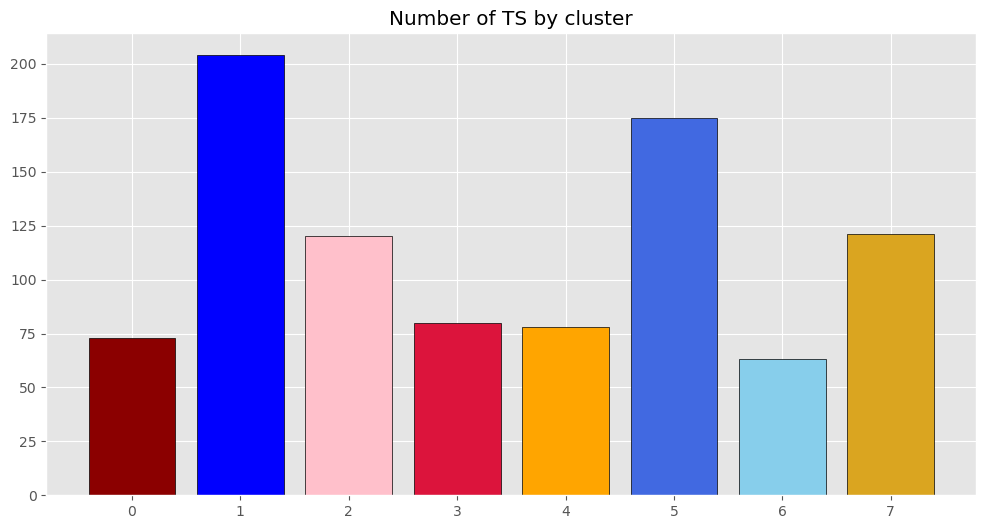


KMeans inertia:  7.519296943797265



In [38]:
# centroids
centroids_paa = kmeans_paa.cluster_centers_
print('Centroids\' shape',centroids_paa.shape)
print()

# inverse transform
#df_centroids_paa = dft_inverse_trasform(np.squeeze(centroids_paa), n_coefs=centroids_paa.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_paa)):
#    c = np.array(df_centroids_paa[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_paa = kmeans_paa.labels_
print('KMeans assigned labels:\n',km_labels_paa)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_paa, return_counts=True)[0], np.unique(km_labels_paa, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_paa = kmeans_paa.inertia_
print('KMeans inertia: ', inertia_paa)
print()

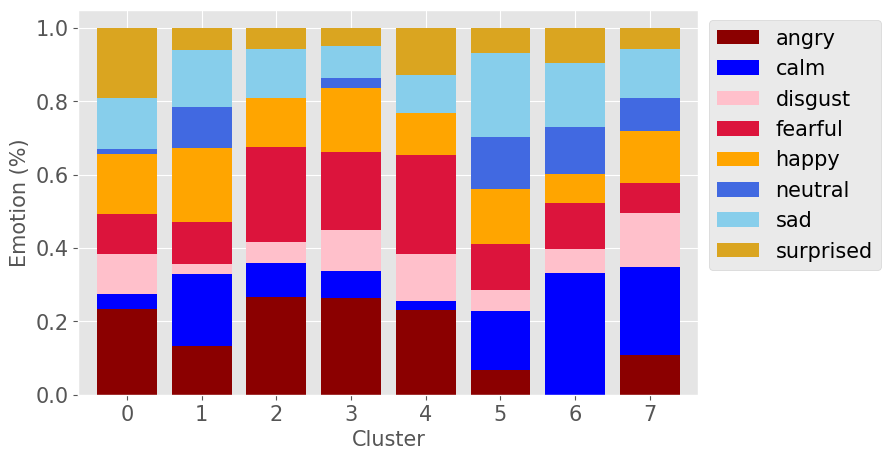



Adjusted_mutual_info_score = 0.048
Adjusted_rand_score = 0.022
Fowlkes_mallows_score = 0.159
Silhouette_score = -0.037


In [39]:
# emotions' distribution within different clusters and evaluation measures
res_km_paa = plot_eval_clust(km_labels_paa, y_clust_paa, X_clust_paa, 'km_paa')
results['km_paa'] = res_km_paa

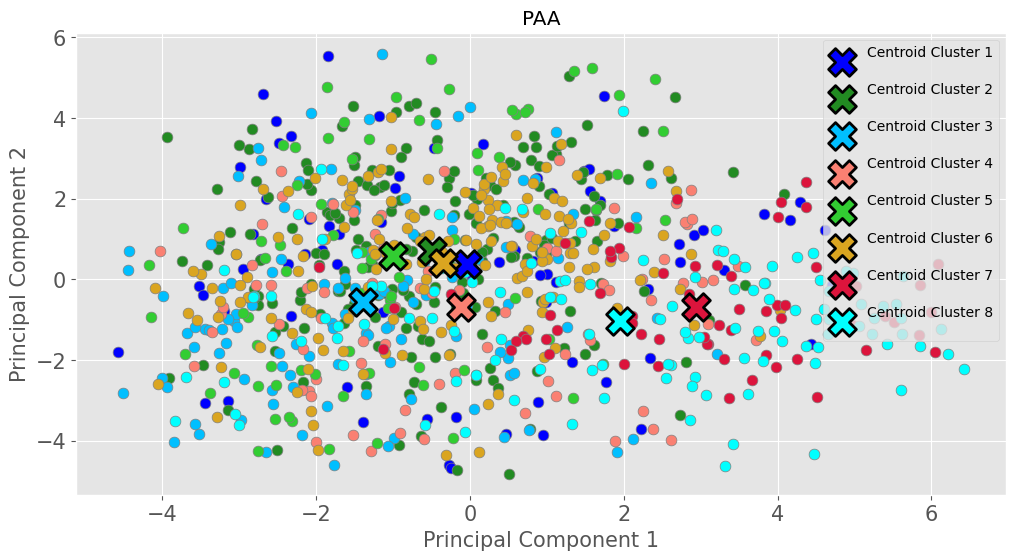

In [40]:
plot_pca_clust(X_clust_paa,km_labels_paa,'paa')

### DFT

In [41]:
X_clust_dft, y_clust_dft, df_dft = imp_data('data_ts\data_p_100_dft.csv', 'data_ts\\ts_p_100_dft.npy', fraction = fraction, emotions = n_clusters)
print(df_dft.shape)
df_dft.head()

(914, 101)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3,-2.060574e-13,-1081.533127,-259.172778,103.926630,252.167121,517.428277,1.506656,-205.064787,-136.939222,-292.856087,35.475299,49.701919,-75.657407,25.465766,-37.662040,-255.289737,-14.494962,33.666756,-114.011293,-173.547427,54.710528,202.662141,190.007841,-146.549194,-266.254433,-134.865365,194.617961,362.166930,216.437506,-215.565708,-225.097505,99.176218,276.605661,121.928578,-79.439505,128.796633,90.344068,-209.763958,-53.834926,327.894794,92.201985,-133.086138,-98.598408,-97.690072,47.174777,168.689791,-143.467463,-188.018199,90.043927,21.130115,-162.642795,32.175801,51.671031,-85.081086,-28.271201,38.744321,-39.901411,-70.203436,45.896527,74.679880,40.026352,-116.916500,-7.529102,27.999239,108.465370,6.229825,-36.564019,-75.071891,45.958741,4.841401,57.665970,66.286775,-94.704597,-26.629103,102.792221,25.396227,-48.705006,37.105110,34.826157,-10.184894,32.579952,77.798389,-66.440086,-148.222939,25.867055,127.557412,1.326456,-16.748969,-56.280664,-68.008503,-42.603401,21.759790,85.685310,19.666203,-109.706415,-55.133414,36.925926,-19.834824,-20.952593,-13.150775
1,7,5.968559e-13,-238.868446,-151.609030,485.351136,-118.668311,125.613750,453.015520,-285.622251,-270.787584,-97.762318,258.609827,-518.600855,-67.820943,45.210923,378.255733,5.806225,228.972695,182.635366,-81.408981,-303.444125,58.588116,223.617565,-155.896805,30.444634,245.452080,-297.814072,-179.904312,70.296895,259.529963,115.265293,274.739595,64.331924,97.267507,-10.363254,36.087215,24.396759,-61.395918,160.980582,68.611099,-95.679501,-72.745819,26.628341,68.331989,-100.083929,112.738440,58.164732,144.098762,-3.700121,-17.848192,49.525465,17.407750,-23.631812,42.932172,-31.977478,61.689443,44.152159,-20.296055,-45.373791,-44.454506,-89.218709,44.787829,-104.910375,49.892119,73.888402,47.074044,54.796988,-1.841606,-71.223536,-19.951561,-94.233668,38.438427,27.477913,77.958887,31.832874,21.098153,-42.568388,-54.029376,-47.135354,81.547163,77.125111,16.954849,8.674048,21.808055,17.789041,-2.254668,-3.749750,23.937634,27.457644,83.555804,7.738362,16.944663,-25.263008,-20.385420,23.946144,-18.872558,-32.460217,88.088459,-32.449549,-20.802644,-12.352910
2,3,-2.433609e-13,-208.783654,197.315144,-287.555455,114.312084,-464.595033,399.246948,-248.475670,413.433369,-350.374356,75.326208,-192.860574,-187.658062,272.024058,533.445804,145.538606,-267.260571,-238.471788,-147.069358,112.286830,-5.647101,-271.740966,-167.794570,47.469793,282.131762,-88.940146,-150.093300,64.826964,242.844681,-2.436245,-89.278103,-26.466143,-216.372838,264.883940,186.569663,-175.222689,-79.314336,-150.084717,-144.198717,20.334747,-32.356837,171.580098,-103.177631,-205.113689,220.807914,-112.888110,116.741646,187.330899,-67.189103,154.313526,61.241510,-118.765021,-124.446508,-57.886572,-104.995404,68.943178,91.706893,-5.833275,46.814972,17.147209,-65.558578,10.096095,-10.700947,-42.463000,-21.821308,27.622528,78.622811,-10.393734,-22.980918,-16.502209,71.695277,52.319710,-45.613641,-41.794257,-27.480601,80.302533,52.131683,-123.147614,-24.864966,-95.432363,-66.261554,74.518820,-43.480591,67.879095,55.820990,11.852119,46.736008,130.236427,-7.250289,1.350635,-32.076708,-85.600376,105.788410,-79.419211,-18.350186,46.443944,-40.135127,64.653013,11.249015,-93.212091
3,3,-2.113865e-13,-227.707630,-149.956614,286.780668,-314.348732,-425.380546,-441.283949,-302.841739,-621.088956,62.602039,-408.717270,-135.836112,275.419809,-135.691299,-95.151905,-1.016515,158.034136,-70.439964,-341.321606,76.023554,142.336757,-140.265267,-36.871314,-86.759375,-45.720811,100.548944,-71.777225,-113.656235,27.233673,-20.890060,-162.877561,140.864366,-13.927556,-415.460975,-96.589796,55.579847,42.475782,-269.561374,104.42

In [42]:
print('____________________DFT____________________')
print()

# computing kMeans
kmeans_dft = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=5, init='k-means++', random_state=100, max_iter_barycenter=5)
kmeans_dft.fit(X_clust_dft)

____________________DFT____________________



TimeSeriesKMeans(max_iter=5, max_iter_barycenter=5, metric='dtw', n_clusters=8,
                 random_state=100)

Centroids' shape (8, 100, 1)

KMeans assigned labels:
 [4 3 0 2 6 3 6 6 0 5 4 3 1 7 5 6 1 3 4 4 3 2 2 6 2 6 1 1 4 6 1 1 4 4 0 2 7
 4 6 0 1 0 7 1 0 2 7 0 4 6 0 3 6 7 3 3 0 0 4 7 0 2 5 6 4 1 0 0 5 2 2 6 2 2
 3 3 2 2 2 1 7 4 3 7 1 1 3 0 4 2 6 2 6 2 4 2 7 3 3 6 5 4 5 4 6 0 0 4 5 3 2
 7 7 4 1 1 7 4 0 3 1 0 7 6 0 4 2 4 2 3 2 3 3 4 3 3 6 6 5 1 3 3 2 7 1 2 4 3
 6 6 2 3 5 7 4 4 4 4 4 2 6 5 3 3 2 4 4 6 2 6 1 0 3 0 4 7 1 3 7 0 7 2 7 1 0
 0 5 2 4 0 6 7 4 0 2 4 0 3 5 2 7 2 7 2 3 0 2 4 2 2 7 0 5 0 1 4 1 3 7 3 4 5
 2 0 0 6 4 4 3 2 6 4 0 4 7 3 4 3 7 1 4 2 0 3 2 7 4 0 3 3 3 7 4 5 1 0 0 4 4
 4 0 3 6 5 1 6 3 4 1 0 5 0 4 5 1 5 4 7 1 7 2 5 7 0 4 4 7 0 5 0 0 6 0 6 6 3
 3 6 1 2 6 6 6 4 5 0 1 5 6 5 0 2 4 3 6 7 1 4 7 5 4 4 7 0 3 6 6 4 3 6 0 4 5
 4 1 0 5 7 6 7 1 6 3 4 6 7 2 7 6 4 1 2 0 4 7 0 0 2 1 5 7 0 2 7 4 7 7 3 4 1
 0 7 3 2 5 1 4 0 6 4 2 6 0 6 6 1 6 4 4 3 6 0 3 4 0 0 4 5 0 1 4 6 4 3 6 1 6
 4 0 0 7 7 0 0 6 4 6 4 2 6 5 5 3 1 4 1 6 0 1 7 0 3 2 2 6 0 5 4 2 6 5 0 6 6
 4 6 6 0 3 2 7 4 1 1 3 4 6 0 2 4 5 3 4 0 6 2 

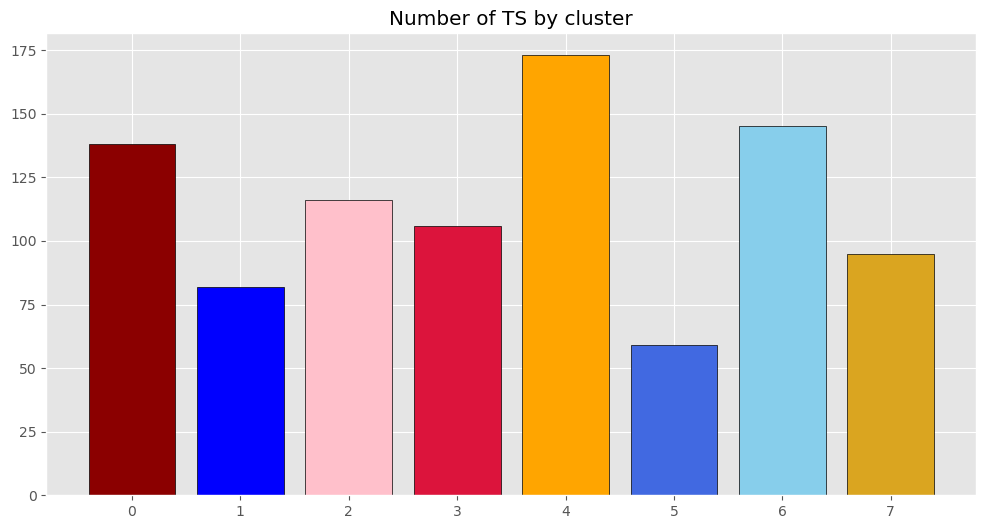


KMeans inertia:  737537.4452682415



In [43]:
# centroids
centroids_dft = kmeans_dft.cluster_centers_
print('Centroids\' shape',centroids_dft.shape)
print()

# inverse transform
#df_centroids_dft = dft_inverse_trasform(np.squeeze(centroids_dft), n_coefs=centroids_dft.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_dft)):
#    c = np.array(df_centroids_dft[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_dft = kmeans_dft.labels_
print('KMeans assigned labels:\n',km_labels_dft)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_dft, return_counts=True)[0], np.unique(km_labels_dft, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_dft = kmeans_dft.inertia_
print('KMeans inertia: ', inertia_dft)
print()

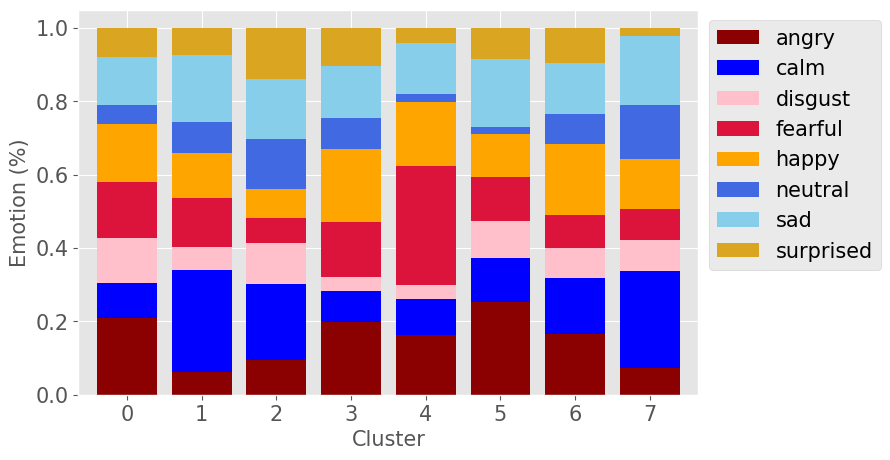



Adjusted_mutual_info_score = 0.028
Adjusted_rand_score = 0.02
Fowlkes_mallows_score = 0.153
Silhouette_score = -0.018


In [44]:
# emotions' distribution within different clusters and evaluation measures
res_km_dft = plot_eval_clust(km_labels_dft, y_clust_dft, X_clust_dft, 'km_dft')
results['km_dft'] = res_km_dft

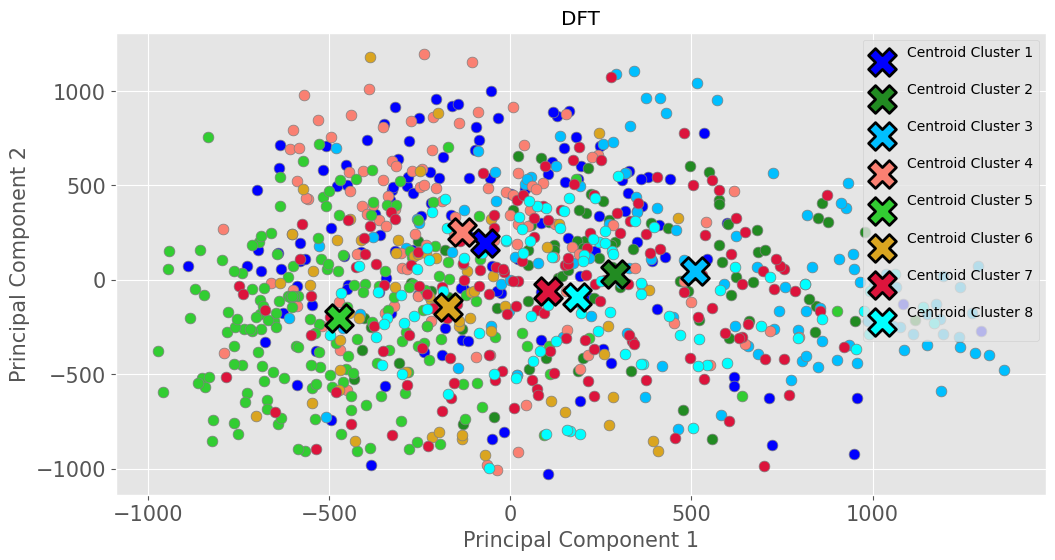

In [45]:
plot_pca_clust(X_clust_dft,km_labels_dft,'dft')

In [46]:
print('DTW')
pd.DataFrame(results.values()).T

DTW


,0,1,2
adjusted_mutual_info_score_KM_SAX,0.058544,NaN,NaN
adjusted_rand_score_KM_SAX,0.035305,NaN,NaN
fowlkes_mallows_score_KM_SAX,0.169809,NaN,NaN
silhouette_score_KM_SAX,-0.022610,NaN,NaN
adjusted_mutual_info_score_KM_PAA,NaN,0.048347,NaN
adjusted_rand_score_KM_PAA,NaN,0.021763,NaN
fowlkes_mallows_score_KM_PAA,NaN,0.159113,NaN
silhouette_score_KM_PAA,NaN,-0.036927,NaN
adjusted_mutual_info_score_KM_DFT,NaN,NaN,0.027799
adjusted_rand_score_KM_DFT,NaN,NaN,0.020427


#### DFT is the best...

## Hierarchical Clustering

- For the COMPLETE method, we used as distance DTW
- For the WARD method we could only use EUCLIDEAN metric

In [47]:
results['km_dft'].values()

dict_values([0.027799278313988138, 0.020427454535483752, 0.1526985446416916, -0.01817415879365825])

### SAX

In [48]:
d_sax, d_mat_sax = dtw_and_matrix(X_clust_sax)

### Complete Linkage

Cophenetic Coefficient: 0.375431496273806


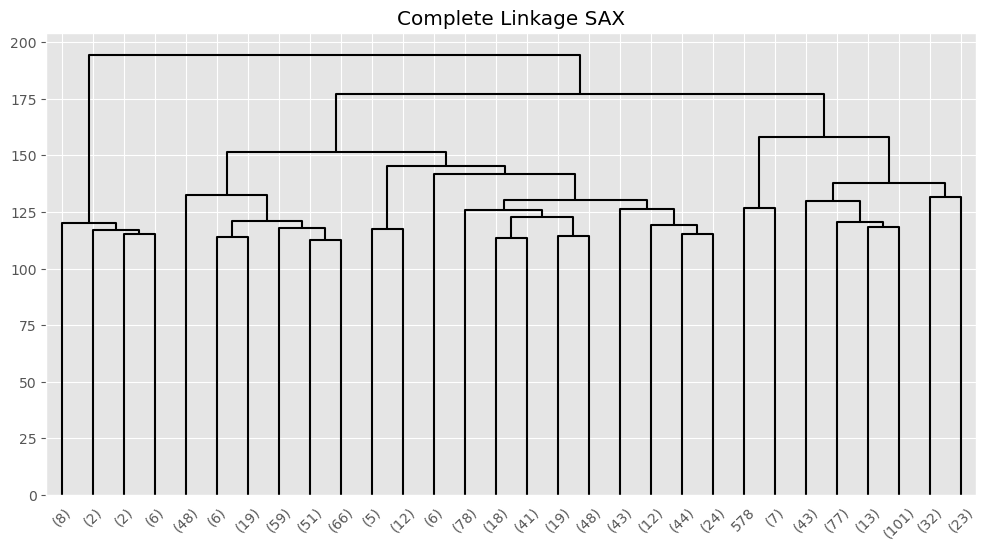

In [49]:
plot_dendr(d_sax,'sax','complete',color_threshold = 8)

### Ward's method

Cophenetic Coefficient: 0.31225653978703954


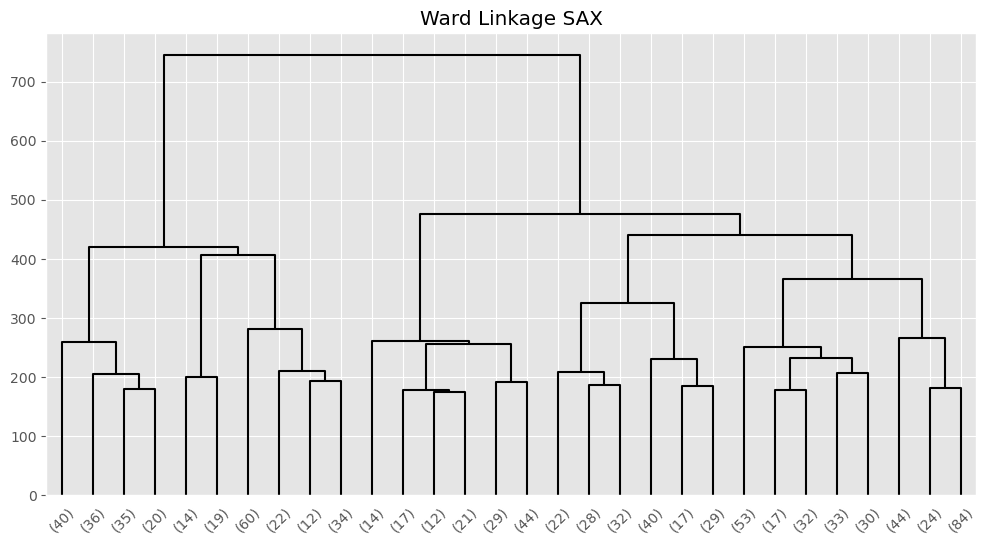

In [50]:
plot_dendr(d_sax,'sax','ward',color_threshold=23)

2    327
0    249
3    234
1     55
7     18
5     17
4      8
6      6
dtype: int64


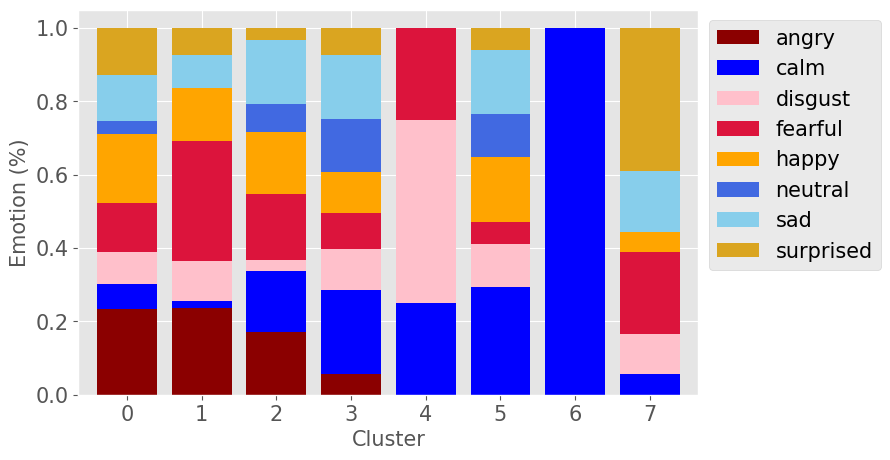



Adjusted_mutual_info_score = 0.054
Adjusted_rand_score = 0.026
Fowlkes_mallows_score = 0.214
Silhouette_score = -0.04


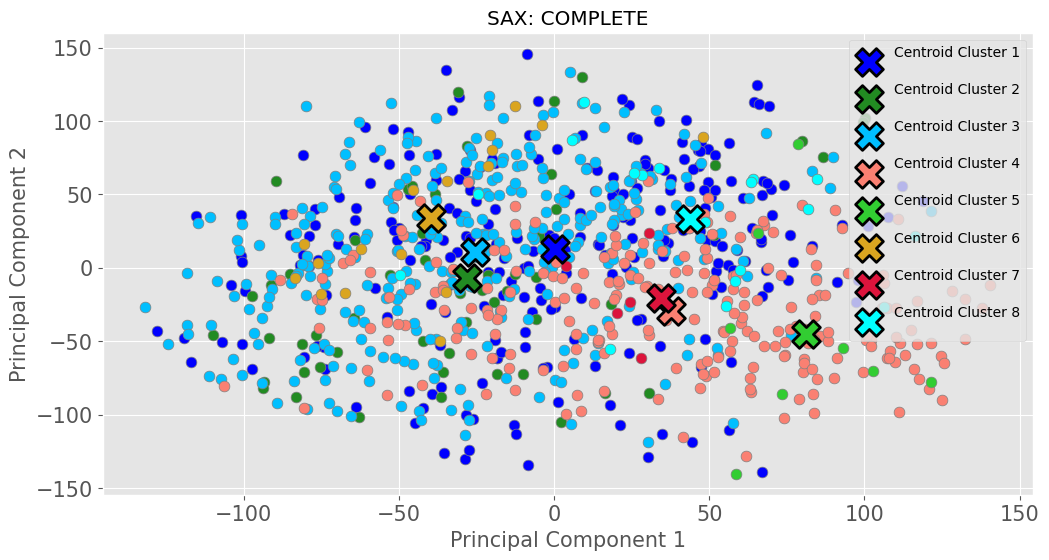

2    176
0    174
5    126
1    125
3     93
6     92
4     88
7     40
dtype: int64


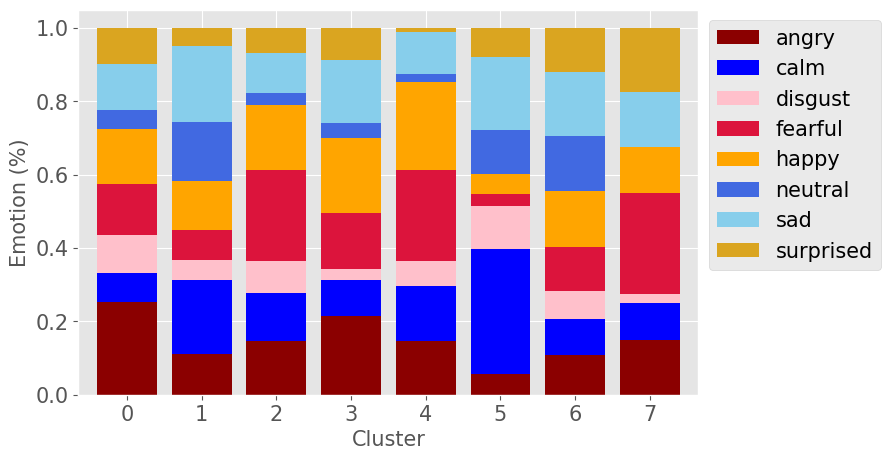



Adjusted_mutual_info_score = 0.038
Adjusted_rand_score = 0.023
Fowlkes_mallows_score = 0.158
Silhouette_score = 0.038


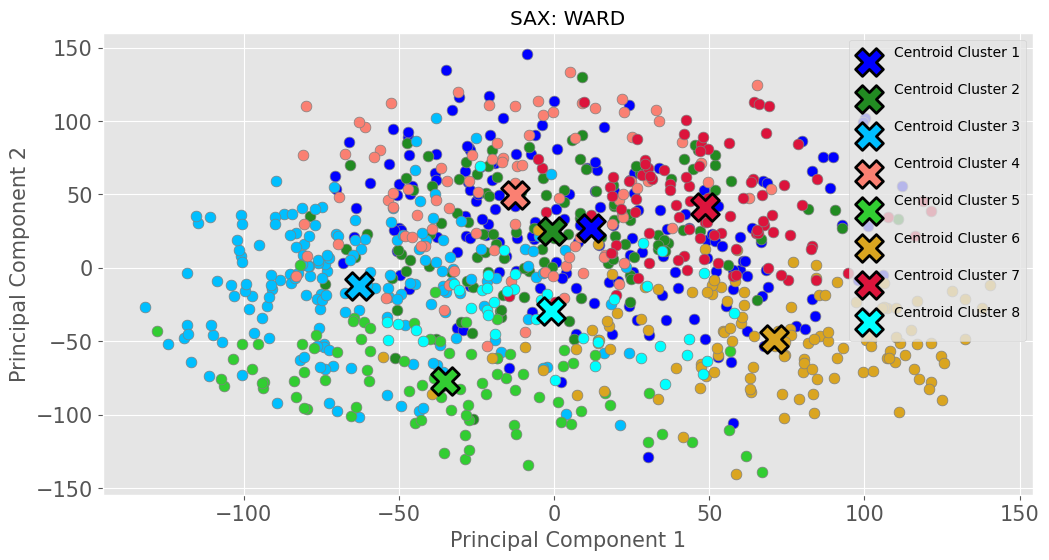

In [51]:
# clustering
data = [d_mat_sax, X_clust_sax]
affinity = ['precomputed','euclidean']
link = ['complete','ward']
for a,l,d in zip(affinity, link, data):
    agg = AgglomerativeClustering(n_clusters = n_clusters, metric = a, linkage = l)
    agg.fit(d)
    labels = agg.labels_
    print(pd.Series(labels).value_counts(), sep = ', ')
    plot_eval_clust(labels, y_clust_sax, X_clust_sax)
    plot_pca_clust(X_clust_sax, labels, f'sax: {l}')
#plot_pca_clust(X_clust_sax, y_clust_sax, 'original')

### PAA

In [52]:
d_paa, d_mat_paa = dtw_and_matrix(X_clust_paa)

### Complete Linkage

Cophenetic Coefficient: 0.4143259976504272


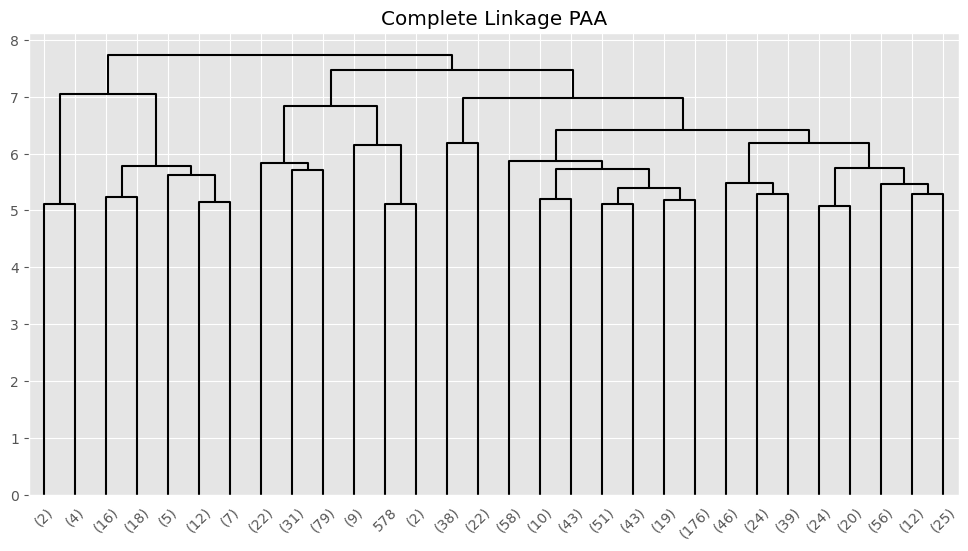

In [53]:
plot_dendr(d_paa,'paa','complete',color_threshold=2.1)

### Ward's method

Cophenetic Coefficient: 0.29698294803626296


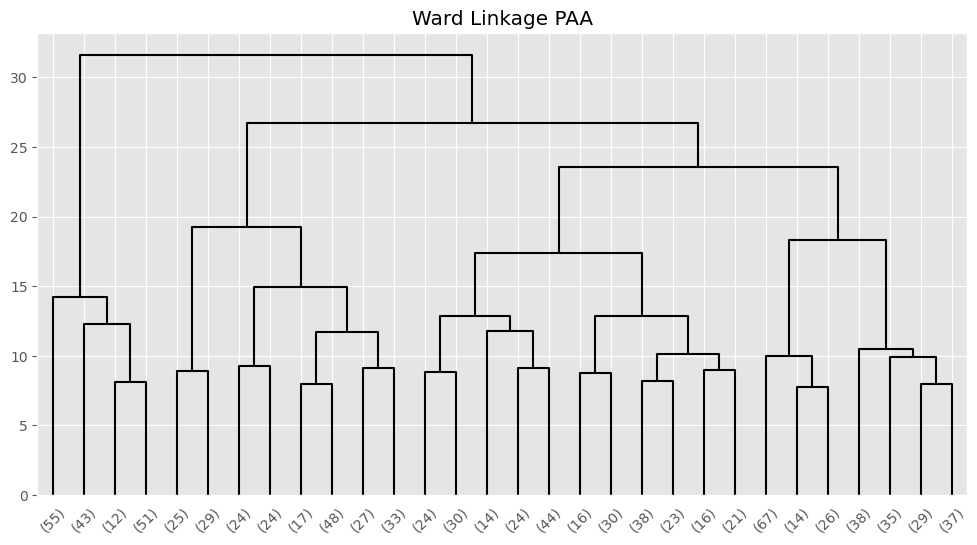

In [54]:
plot_dendr(d_paa,'paa','ward',color_threshold=3.5)

6    400
0    246
5    132
1     58
7     38
4     22
2     12
3      6
dtype: int64


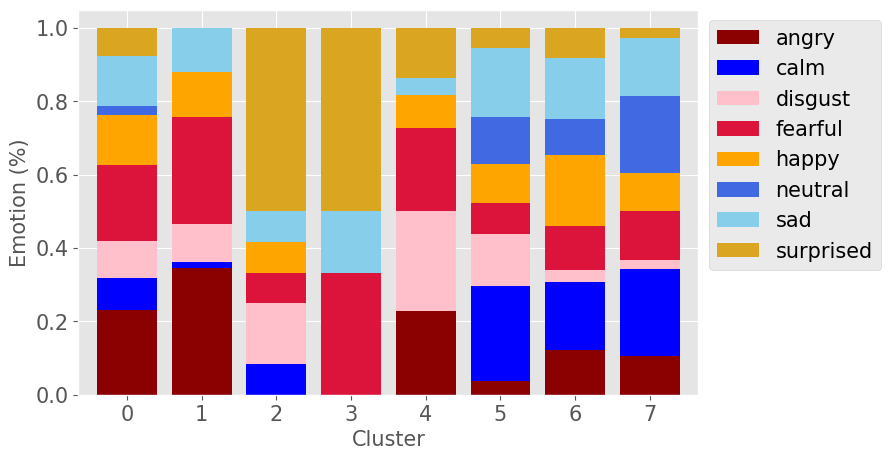



Adjusted_mutual_info_score = 0.054
Adjusted_rand_score = 0.024
Fowlkes_mallows_score = 0.219
Silhouette_score = -0.026


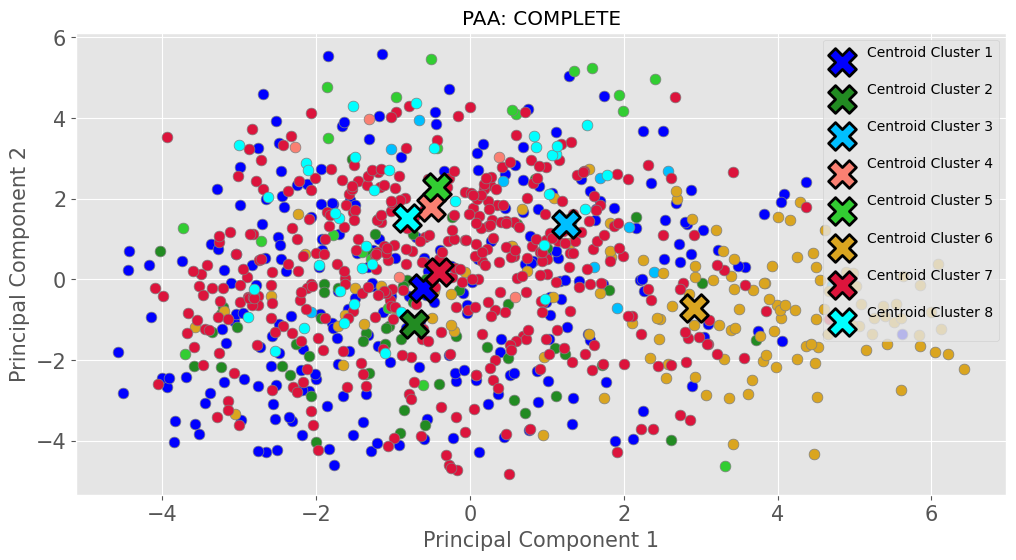

4    183
0    158
3    138
2    137
1     93
6     74
7     69
5     62
dtype: int64


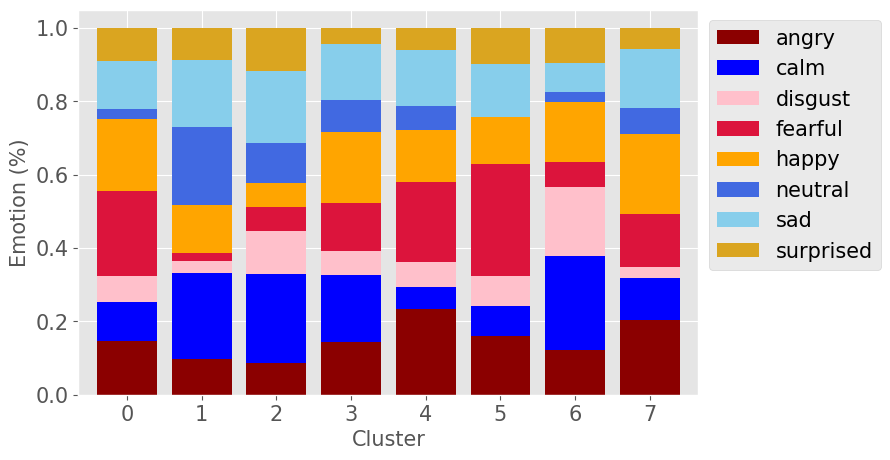



Adjusted_mutual_info_score = 0.035
Adjusted_rand_score = 0.02
Fowlkes_mallows_score = 0.155
Silhouette_score = 0.025


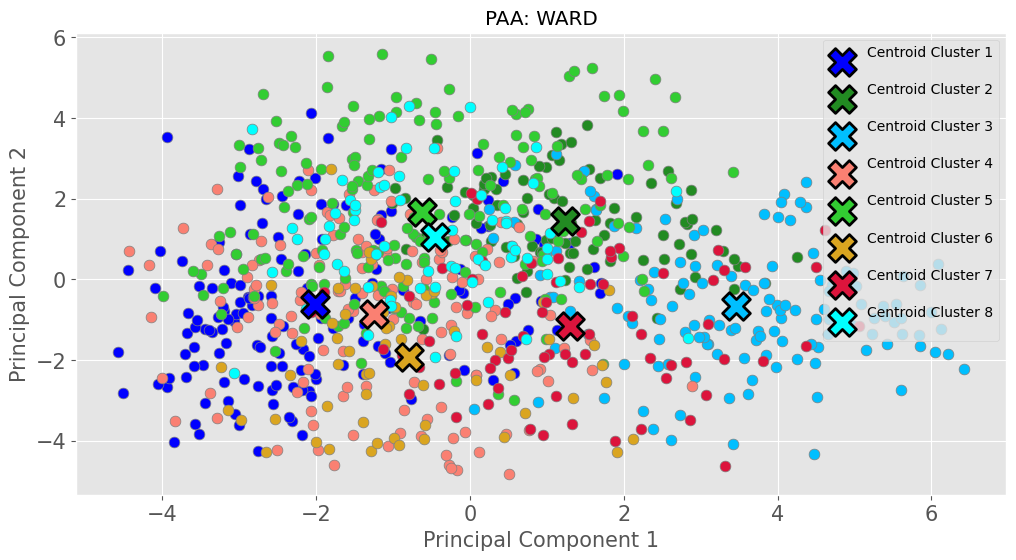

In [55]:
# clustering
data = [d_mat_paa, X_clust_paa]
affinity = ['precomputed','euclidean']
link = ['complete','ward']
for a,l,d in zip(affinity, link, data):
    agg = AgglomerativeClustering(n_clusters = n_clusters, metric = a, linkage = l)
    agg.fit(d)
    labels = agg.labels_
    print(pd.Series(labels).value_counts(), sep = ', ')
    plot_eval_clust(labels, y_clust_paa, X_clust_paa)
    plot_pca_clust(X_clust_paa, labels, f'paa: {l}')
#plot_pca_clust(X_clust_paa, y_clust_paa, 'original')

### DFT

In [56]:
d_dft, d_mat_dft = dtw_and_matrix(X_clust_dft)

### Complete Linkage

Cophenetic Coefficient: 0.4761481216925724


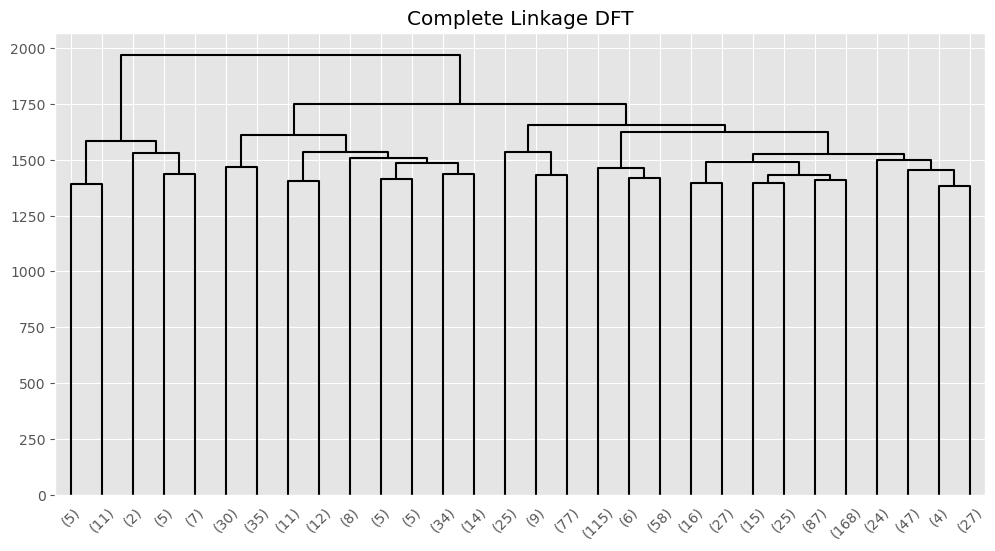

In [57]:
plot_dendr(d_dft,'dft','complete',color_threshold=2.2)

### Ward's method

Cophenetic Coefficient: 0.3827683274284886


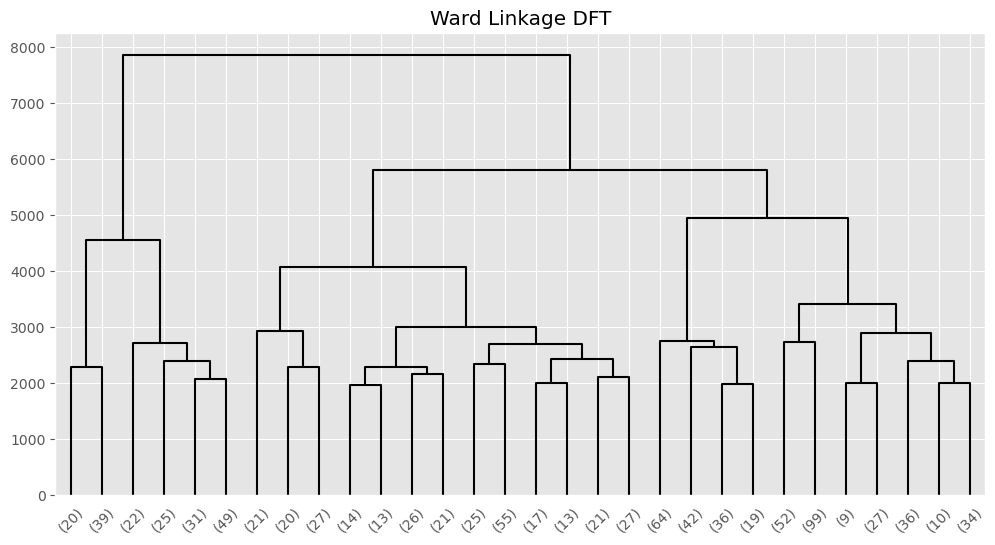

In [58]:
plot_dendr(d_dft,'dft','ward',color_threshold=4)

2    440
4    179
0    111
3     66
5     65
7     23
6     16
1     14
dtype: int64


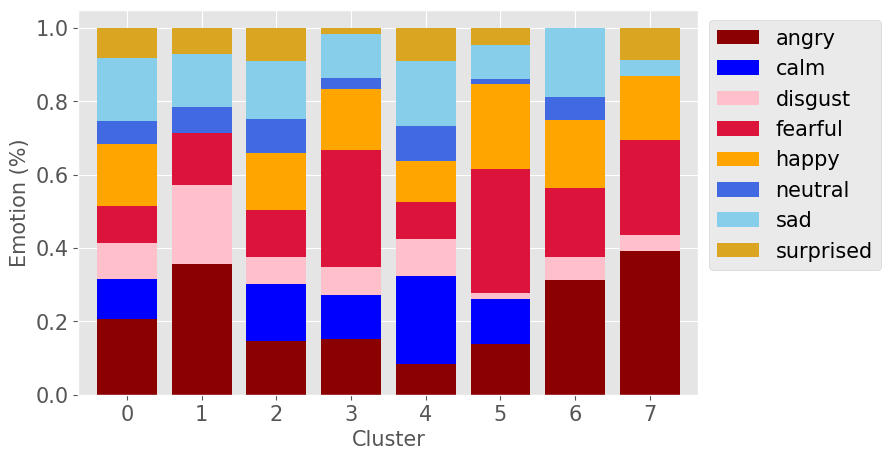



Adjusted_mutual_info_score = 0.022
Adjusted_rand_score = 0.001
Fowlkes_mallows_score = 0.2
Silhouette_score = -0.008


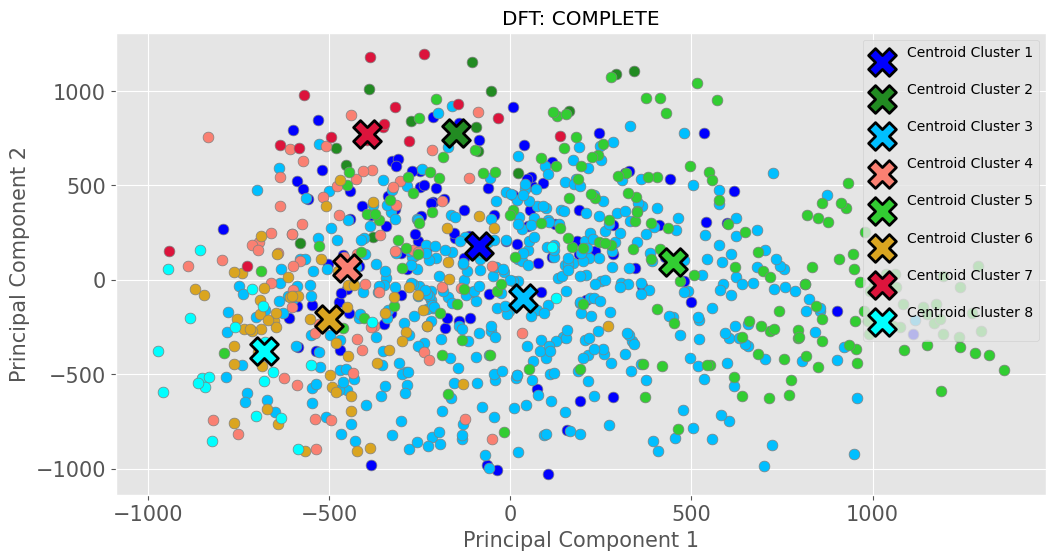

1    151
2    134
0    127
5    125
7    111
4     95
3     95
6     76
dtype: int64


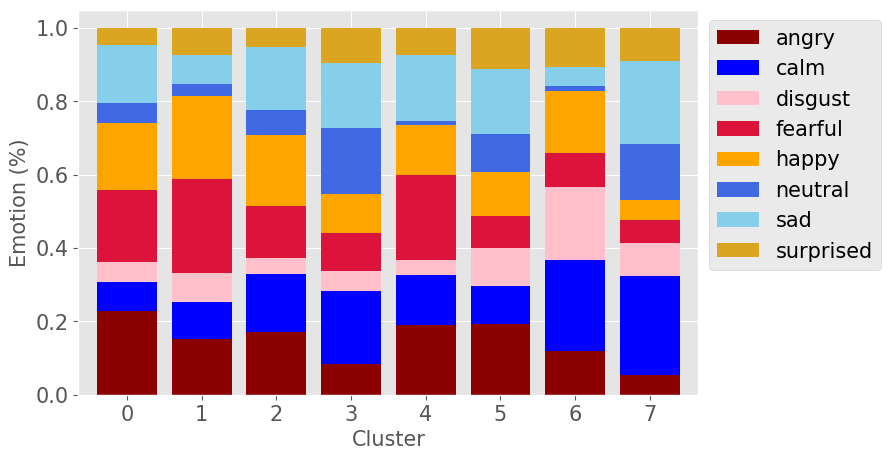



Adjusted_mutual_info_score = 0.033
Adjusted_rand_score = 0.019
Fowlkes_mallows_score = 0.148
Silhouette_score = 0.026


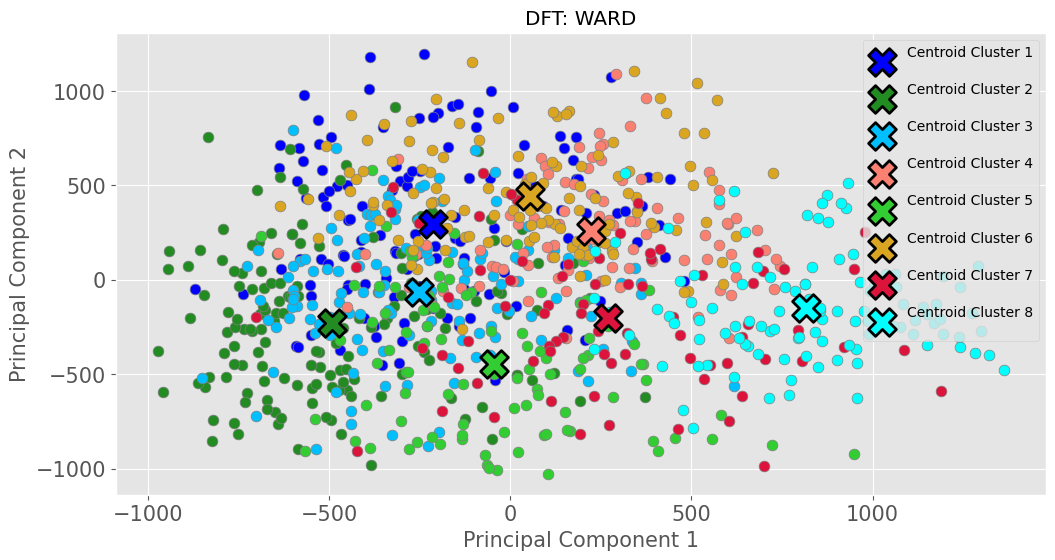

In [59]:
# clustering
data = [d_mat_dft, X_clust_dft]
affinity = ['precomputed','euclidean']
link = ['complete','ward']
for a,l,d in zip(affinity, link, data):
    agg = AgglomerativeClustering(n_clusters = n_clusters, metric = a, linkage = l)
    agg.fit(d)
    labels = agg.labels_
    print(pd.Series(labels).value_counts(), sep = ', ')
    plot_eval_clust(labels, y_clust_dft, X_clust_dft)
    plot_pca_clust(X_clust_dft, labels, f'dft: {l}')
#plot_pca_clust(X_clust_dft, y_clust_dft, 'original')